In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install evaluate

In [ ]:
import os
import re
import torch
from torch.utils.data import Dataset
from PIL import Image

class IAMDataset(Dataset):
    def __init__(self, df, processor, max_target_length=128, root_dir=""):
        """
        Args:
            df (pd.DataFrame): DataFrame with columns ['image_path', 'label']
            processor: TrOCRProcessor (or similar) for image+text preprocessing
            max_target_length (int): Max length for text tokens
            root_dir (str): (Optional) Base directory to prepend to image_path
        """
        self.df = df.reset_index(drop=True)
        self.processor = processor
        self.max_target_length = max_target_length
        self.root_dir = root_dir  # if you need to prepend a folder path

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # 1. Read columns from DataFrame
        image_path = self.df.loc[idx, "image_path"]  # full or partial path
        text = self.df.loc[idx, "label"]

        # 2. Clean up text
        text = self.clean_text(text)

        # 3. Load and preprocess image
        #    If 'image_path' is already full, we just use it directly.
        #    Otherwise, combine with root_dir if needed:
        # full_image_path = os.path.join(self.root_dir, image_path)
        # image = self.load_and_preprocess_image(full_image_path)
        image = self.load_and_preprocess_image(image_path)

        # 4. Process image (resizing, normalization, etc.) with processor
        pixel_values = self.processor(image, return_tensors="pt").pixel_values

        # 5. Tokenize text
        labels = self.processor.tokenizer(
            text,
            padding="max_length",
            max_length=self.max_target_length,
            truncation=True
        ).input_ids

        # Replace padding token ID with -100 so they’re ignored in loss
        labels = [
            label if label != self.processor.tokenizer.pad_token_id else -100
            for label in labels
        ]

        return {
            "pixel_values": pixel_values.squeeze(),
            "labels": torch.tensor(labels, dtype=torch.long)
        }

    def clean_text(self, text):
        """Applies text preprocessing steps (strip, collapse spaces, remove non-printables)."""
        text = text.strip()
        text = re.sub(r"\s+", " ", text)  # collapse multiple spaces
        text = text.encode("utf-8", "ignore").decode("utf-8")
        text = "".join(c for c in text if c.isprintable())
        return text

    def load_and_preprocess_image(self, image_path):
        """Loads an image from disk and converts it to RGB."""
        with Image.open(image_path) as img:
            return img.convert("RGB")


In [ ]:
from sklearn.model_selection import train_test_split
# Load the DataFrame from CSV

df = pd.read_csv("/kaggle/input/outputs/output_converted.csv")

# First, split into train+val and test (e.g., 90% train+val, 10% test)
train_val_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

# Now split train_val into train and validation (e.g., 80% train, 20% val of train_val)
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42)

In [ ]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel, Seq2SeqTrainingArguments, Seq2SeqTrainer
import evaluate


# Initialize processor and model
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten",ignore_mismatched_sizes=True)

model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id

# Create datasets
train_dataset = IAMDataset(
    root_dir=train_df["image_path"],  # Update path
    df=train_df,
    processor=processor,
    max_target_length=256  # Adjust based on your max text length
)

val_dataset = IAMDataset(
    root_dir=val_df["image_path"],
    df=val_df,
    processor=processor,
    max_target_length=256
)

test_dataset = IAMDataset(
    root_dir=test_df["image_path"],
    df=test_df,
    processor=processor,
    max_target_length=256
)

In [ ]:
pip install jiwer

In [ ]:
from evaluate import load as load_metric


cer_metric = load_metric("cer")
wer_metric = load_metric("wer")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    pred_str = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(labels, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)
    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer, "wer": wer}

In [ ]:
# Training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./trocr-finetuned",
    predict_with_generate=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=4e-5,
    weight_decay=0.01,
    num_train_epochs=5,
    logging_dir="./logs",
    logging_strategy="steps",
    logging_steps=50,
    save_strategy="epoch",
    fp16=torch.cuda.is_available(),
    report_to="none"
)

In [ ]:
#from transformers import TrOCRProcessor
#processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")

# Define a global tokenizer from the processor
tokenizer = processor.tokenizer

def compute_metrics(eval_pred):
    predictions, label_ids = eval_pred

    # Replace -100 in label_ids with tokenizer.pad_token_id so that batch_decode works correctly.
    safe_label_ids = [
        [token_id if token_id != -100 else tokenizer.pad_token_id for token_id in seq]
        for seq in label_ids
    ]
    
    pred_str = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(safe_label_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)
    wer = wer_metric.compute(predictions=pred_str, references=label_str)
    return {"cer": cer, "wer": wer}


# Create trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=processor,  # Passing processor as tokenizer for training convenience
    compute_metrics=compute_metrics,
)

In [ ]:
import albumentations as A
import numpy as np

# 1. Add Augmentation Transformations
train_augmentations = A.Compose([
    A.Rotate(limit=5, p=0.4),  # ±5 degrees rotation
    A.GaussianBlur(blur_limit=(3, 7), p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
    A.Affine(scale=(0.9, 1.1), shear=(-5,5), p=0.3),  # Mild perspective transforms
    A.OpticalDistortion(distort_limit=0.05, p=0.2),  # Simulate paper curvature
])

# 2. Modify Dataset Class
class AugmentedIAMDataset(IAMDataset):
    def __init__(self, df, processor, max_target_length=128, root_dir="", transform=None):
        super().__init__(df, processor, max_target_length, root_dir)
        self.transform = transform

    def load_and_preprocess_image(self, image_path):
        """Modified to include augmentations"""
        with Image.open(image_path) as img:
            img = img.convert("RGB")
            img_np = np.array(img)
            
            if self.transform:
                augmented = self.transform(image=img_np)
                img_np = augmented["image"]
                
            return img_np  # Return as numpy array for processor

# 3. Create Augmented Datasets
train_dataset = AugmentedIAMDataset(
    df=train_df,
    processor=processor,
    max_target_length=256,
    transform=train_augmentations  # Apply only to training data
)

val_dataset = AugmentedIAMDataset(
    df=val_df,
    processor=processor,
    max_target_length=256,
    transform=None
)

test_dataset = AugmentedIAMDataset(
    df=test_df,
    processor=processor,
    max_target_length=256,
    transform=None
)

# 4. Update Training Arguments for Better Convergence
training_args = Seq2SeqTrainingArguments(
    output_dir="./trocr-finetuned-augmented",
    predict_with_generate=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=3e-5,  # Slightly lower learning rate
    weight_decay=0.02,
    num_train_epochs=8,   # More epochs for augmented data
    logging_dir="./logs",
    logging_steps=100,
    save_strategy="epoch",
    fp16=torch.cuda.is_available(),
    gradient_accumulation_steps=2,  # Better batch normalization
    report_to="none"
)

# 5. Create and Train Enhanced Model
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=processor,
    compute_metrics=compute_metrics,
)

# Start training
trainer.train()

In [ ]:
# 1. Delete all older checkpoints
!rm -rf /kaggle/working/trocr-finetuned-augmented/checkpoint-1352
!rm -rf /kaggle/working/trocr-finetuned-augmented/checkpoint-2028
!rm -rf /kaggle/working/trocr-finetuned-augmented/checkpoint-2704
!rm -rf /kaggle/working/trocr-finetuned-augmented/checkpoint-3380
!rm -rf /kaggle/working/trocr-finetuned-augmented/checkpoint-676

# 2. (Optional) Save the final model state into the checkpoint-4056 folder
#    If your trainer is still in memory with the final trained weights, call:
trainer.save_model("/kaggle/working/trocr-finetuned-augmented/checkpoint-4056")


In [ ]:
!zip -r model.zip /kaggle/working/trocr-finetuned-augmented/checkpoint-4056


In [ ]:
predictions = trainer.predict(test_dataset)

In [ ]:
predictions

In [ ]:
generated_ids = predictions.predictions  # or however your model outputs predictions
decoded_preds = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

print(decoded_preds)

In [ ]:
# Compute metrics using your compute_metrics function
metrics = compute_metrics((predictions.predictions, predictions.label_ids))

print("Test CER:", metrics["cer"])
print("Test WER:", metrics["wer"])

##  pdf to images

In [ ]:
!apt-get update
!apt-get install -y poppler-utils


In [ ]:
pdf_path = "/kaggle/input/pdf-1/Buendia - Instruccion.pdf"  # update with the actual PDF path
pages = convert_from_path(pdf_path, dpi=300)  # Adjust DPI as needed

# processing the images to usable form

In [ ]:


# Custom Post-Processing Rules

def remove_accents_except_n(text):
    normalized = unicodedata.normalize('NFD', text)
    filtered = ''.join(
        ch for ch in normalized
        if (unicodedata.category(ch) != 'Mn' or ch in ['ñ', 'Ñ'])
    )
    return unicodedata.normalize('NFC', filtered)

def apply_macron_rules(text):
    text = re.sub(r'(Q)\u00AF', r'\1ue', text)       # Q¯ -> Que
    text = re.sub(r'([^Qq])\u00AF', r'\1n', text)      # other x¯ -> xn
    return text.replace('\u00AF', '')

def normalize_text(text):
    text = text.replace('ſ', 's')
    text = remove_accents_except_n(text)
    text = text.replace('ç', 'z')
    text = apply_macron_rules(text)
    return text


# 2. Line Detection (Naive)

def detect_lines(image, threshold=200):
    """
    Convert to grayscale, then detect horizontal 'blank' rows to segment lines.
    `threshold` controls what counts as blank vs text.
    Returns a list of (y_start, y_end) for each line.
    """
    gray_img = image.convert("L")  # grayscale
    np_img = np.array(gray_img)
    row_sums = np.mean(np_img, axis=1)
    
    lines = []
    in_line = False
    start = 0
    for i, val in enumerate(row_sums):
        if val < threshold and not in_line:
            in_line = True
            start = i
        elif val >= threshold and in_line:
            in_line = False
            end = i
            lines.append((start, end))
    if in_line:
        lines.append((start, len(row_sums)))
    return lines

def crop_and_resize(image, y_start, y_end, target_size=(384, 384)):
    """
    Crop the image between y_start and y_end, then resize to target_size.
    """
    cropped = image.crop((0, y_start, image.width, y_end))
    resized = cropped.resize(target_size, Image.BILINEAR)
    return resized


# 3. OCR Pipeline with Filtering by Line Height

def ocr_image_with_resizing(
    image_path,
    model,
    tokenizer,
    processor,
    device,
    target_size=(384, 384),
    line_threshold=200,
    height_lower_factor=0.7,
    height_upper_factor=1.3
):
    # Open image in RGB
    original_image = Image.open(image_path).convert("RGB")

    # Detect lines
    lines = detect_lines(original_image, threshold=line_threshold)
    print(f"Detected {len(lines)} lines in the image.")

    if not lines:
        print("No lines detected!")
        return ""
    
    # Compute line heights and median height
    line_heights = [y_end - y_start for (y_start, y_end) in lines]
    median_height = np.median(line_heights)
    print(f"Median line height: {median_height:.2f}")

    # For debugging, display the original image
    plt.figure(figsize=(8, 8))
    plt.imshow(original_image)
    plt.axis("off")
    plt.title("Original Image")
    plt.show()

    recognized_lines = []
    for idx, (y_start, y_end) in enumerate(lines):
        current_height = y_end - y_start
        # Skip lines that are too big or too small compared to median height
        if current_height < median_height * height_lower_factor or current_height > median_height * height_upper_factor:
            print(f"Skipping line {idx+1} (height: {current_height}) as it deviates from median.")
            continue

        # Crop and resize the line region
        line_img = crop_and_resize(original_image, y_start, y_end, target_size=target_size)

        # Optional: Display the cropped line
        plt.figure(figsize=(6, 2))
        plt.imshow(line_img)
        plt.axis("off")
        plt.title(f"Line {idx+1}")
        plt.show()

        # Preprocess for the model
        inputs = processor(line_img, return_tensors="pt")
        pixel_values = inputs.pixel_values.to(device)

        # Generate prediction
        generated_ids = model.generate(
            pixel_values,
            max_new_tokens=128, 
            num_beams=5, 
            early_stopping=True
        )
        raw_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
        final_text = normalize_text(raw_text)
        recognized_lines.append(final_text)
        print(f"Line {idx+1} OCR: {final_text}")

    full_text = "\n".join(recognized_lines)
    return full_text


# 4. Main Usage Example

if __name__ == "__main__":
    # Load your model, tokenizer, and processor
    
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Path to the sample image
    image_path = "/kaggle/input/sample-test/Screenshot 2025-04-01 at 12.24.48PM.png"
    full_text = ocr_image_with_resizing(
        image_path=image_path,
        model=model,
        tokenizer=tokenizer,
        processor=processor,
        device=device,
        target_size=(384, 384),
        line_threshold=200
    )

    print("\nFinal OCR Text:")
    print(full_text)


In [ ]:





# 2. Line Detection (Naive)

def detect_lines(image, threshold=200):
    """
    Convert to grayscale, then detect horizontal 'blank' rows to segment lines.
    `threshold` controls what counts as blank vs text.
    Returns a list of (y_start, y_end) for each line.
    """
    gray_img = image.convert("L")  # grayscale
    np_img = np.array(gray_img)

    # Sum pixel values row-wise; rows that are "blank" have high sum (white).
    # Invert logic if your text is white on black, etc.
    row_sums = np.mean(np_img, axis=1)
    
    # We'll consider a row 'blank' if its average pixel value is above `threshold`.
    # Then we find contiguous runs of 'non-blank' rows to define lines.
    lines = []
    in_line = False
    start = 0

    for i, val in enumerate(row_sums):
        if val < threshold and not in_line:
            # We enter text region
            in_line = True
            start = i
        elif val >= threshold and in_line:
            # We exit text region
            in_line = False
            end = i
            lines.append((start, end))

    # If the image ends while still in a line
    if in_line:
        lines.append((start, len(row_sums)))

    return lines

def crop_and_resize(image, y_start, y_end, target_size=(384, 384)):
    """
    Crop the image between y_start and y_end, then resize to target_size.
    """
    # Crop: left, upper, right, lower
    cropped = image.crop((0, y_start, image.width, y_end))

    # Resize to target_size for consistent input
    resized = cropped.resize(target_size, Image.BILINEAR)
    return resized

# -----------------------------
# 3. OCR Pipeline
# -----------------------------
def ocr_image_with_resizing(
    image_path,
    model,
    tokenizer,
    processor,
    device,
    target_size=(384, 384),
    line_threshold=200
):
    # Open image in RGB
    original_image = Image.open(image_path).convert("RGB")

    # Detect lines
    lines = detect_lines(original_image, threshold=line_threshold)
    print(f"Detected {len(lines)} lines in the image.")

    # For debugging, display the original image
    plt.figure(figsize=(8, 8))
    plt.imshow(original_image)
    plt.axis("off")
    plt.title("Original Image")
    plt.show()

    # Store all recognized lines here
    recognized_lines = []

    for idx, (y_start, y_end) in enumerate(lines):
        # Crop and resize the line region
        line_img = crop_and_resize(original_image, y_start, y_end, target_size=target_size)

        # Display the line chunk (optional)
        plt.figure(figsize=(6, 2))
        plt.imshow(line_img)
        plt.axis("off")
        plt.title(f"Line {idx+1}")
        plt.show()

        # Preprocess for the model
        inputs = processor(line_img, return_tensors="pt")
        pixel_values = inputs.pixel_values.to(device)

        # Generate prediction
        generated_ids = model.generate(
            pixel_values,
            max_new_tokens=128, 
            num_beams=5, 
            early_stopping=True
        )
        raw_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

        # Post-process
        final_text = normalize_text(raw_text)
        recognized_lines.append(final_text)
        print(f"Line {idx+1} OCR: {final_text}")

    # Combine lines with newlines (or spaces, depending on preference)
    full_text = "\n".join(recognized_lines)
    return full_text


# -----------------------------
# 4. Main Usage Example
# -----------------------------
if __name__ == "__main__":
    # Example model loading
    # model_path = "/kaggle/working/trocr-finetuned-augmented/checkpoint-4056"
    # model = AutoModelForSeq2SeqLM.from_pretrained(model_path)
    # tokenizer = AutoTokenizer.from_pretrained(model_path)
    # processor = TrOCRProcessor.from_pretrained(model_path)
    
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # model.to(device)

    # Suppose we already have model, tokenizer, processor loaded as above
    # Example usage:
    image_path = "/kaggle/input/sample-test/Screenshot 2025-04-01 at 12.24.48PM.png"
    full_text = ocr_image_with_resizing(
        image_path=image_path,
        model=model,
        tokenizer=tokenizer,
        processor=processor,
        device=device,
        target_size=(384, 384),       # Adjust to the size your model handles best
        line_threshold=200           # Adjust to detect lines better
    )

    print("\nFinal OCR Text:")
    print(full_text)


In [ ]:



# Custom Post-Processing (if needed)

def remove_accents_except_n(text):
    normalized = unicodedata.normalize('NFD', text)
    filtered = ''.join(ch for ch in normalized if (unicodedata.category(ch) != 'Mn' or ch in ['ñ', 'Ñ']))
    return unicodedata.normalize('NFC', filtered)

def apply_macron_rules(text):
    text = re.sub(r'(Q)\u00AF', r'\1ue', text)       # e.g., Q¯ -> Que
    text = re.sub(r'([^Qq])\u00AF', r'\1n', text)       # e.g., x¯ -> xn
    return text.replace('\u00AF', '')

def normalize_text(text):
    text = text.replace('ſ', 's')
    text = remove_accents_except_n(text)
    text = text.replace('ç', 'z')
    text = apply_macron_rules(text)
    return text


def process_large_image(image_path, output_size=512):
    """
    Load an image, perform thresholding to detect text contours, 
    and extract & resize regions of interest (ROIs) that likely contain text.
    Each ROI is then converted to grayscale to match the model's expected channel config.
    """
    # Load image using OpenCV (BGR)
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image not found at path: {image_path}")
    
    # Convert to grayscale for thresholding
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply threshold (binary inverse with OTSU)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    
    # Find contours of text regions
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    chunks = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        # Filter out very large or very small regions
        if w > img.shape[1] // 2 or h > img.shape[0] // 2:
            continue
        if w < 20 or h < 20:
            continue
        
        # Extract the ROI from the original image (in BGR)
        roi = img[y:y+h, x:x+w]
        # Convert ROI to PIL Image in RGB, then resize
        roi_pil = Image.fromarray(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
        roi_pil = roi_pil.resize((output_size, output_size), Image.BILINEAR)
        # Convert to grayscale (L mode) to match model's expected 1-channel input
        roi_pil = roi_pil.convert("L")
        chunks.append((x, roi_pil))
    
    # Sort chunks left-to-right, top-to-bottom (using x-coordinate)
    chunks.sort(key=lambda x: x[0])
    return [chunk[1] for chunk in chunks]

# -----------------------------
# 2. OCR Inference on Chunks
# -----------------------------
def ocr_inference(chunks, processor, model, tokenizer, device):
    texts = []
    for idx, chunk in enumerate(chunks):
        # Optional: display each chunk
        plt.figure(figsize=(3, 3))
        plt.imshow(chunk, cmap="gray")
        plt.axis("off")
        plt.title(f"Chunk {idx+1}")
        plt.show()

        # Preprocess the chunk using the processor.
        # The chunk is already in grayscale, so the processor should interpret it as 1-channel.
        inputs = processor(chunk, return_tensors="pt").pixel_values.to(device)
        
        # Generate OCR prediction
        generated_ids = model.generate(inputs, max_new_tokens=128, num_beams=5, early_stopping=True)
        raw_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
        final_text = normalize_text(raw_text)
        texts.append(final_text)
        print(f"Chunk {idx+1} OCR: {final_text}")
    
    return "\n".join(texts)

# -----------------------------
# 3. Main Execution
# -----------------------------
if __name__ == "__main__":
    # Load your model, tokenizer, and processor
    
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Path to the large image
    large_image_path = "/kaggle/input/sample-test/Screenshot 2025-04-01 at 12.24.48PM.png"  # Update path if needed
    text_chunks = process_large_image(large_image_path, output_size=512)
    
    # Perform OCR on the processed chunks
    final_text = ocr_inference(text_chunks, processor, model, tokenizer, device)
    
    print("\nExtracted Text:")
    print(final_text)


In [ ]:


# 2. Image processing and chunking function
def process_large_image(image_path, output_size=512):
    # Load image
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Preprocessing - adjust based on your document characteristics
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    
    # Detect text contours (excluding large elements like the 'A')
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    chunks = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        
        # Filter out very large elements (like the initial 'A')
        if w > img.shape[1]//2 or h > img.shape[0]//2:
            continue
            
        # Extract ROI and resize
        roi = img[y:y+h, x:x+w]
        roi_pil = Image.fromarray(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
        chunks.append((x, roi_pil))
    
    # Sort chunks left-to-right, top-to-bottom
    chunks.sort(key=lambda x: (x[0]//output_size, x[0]))
    
    return [chunk[1] for chunk in chunks]

# 3. OCR inference function
def ocr_inference(chunks):
    texts = []
    for chunk in chunks:
        # Preprocess using your model's processor
        pixel_values = processor(chunk, return_tensors="pt").pixel_values.to(device)
        
        # Generate prediction
        generated_ids = model.generate(pixel_values)
        text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        texts.append(text)
    
    return "\n".join(texts)

# 4. Main execution
large_image_path = "/kaggle/input/sample-test/Screenshot 2025-04-01 at 12.24.48PM.png"  h

# Process image into chunks
text_chunks = process_large_image(large_image_path)

# Perform OCR using your model
final_text = ocr_inference(text_chunks)

print("Extracted Text:")
print(final_text)

# loading the model 

In [ ]:


# 1. Load your trained model and processor
model_path = "/kaggle/input/model-final/kaggle/working/trocr-finetuned-augmented/checkpoint-4056"  # Update with your actual path
processor = TrOCRProcessor.from_pretrained(model_path)
model = VisionEncoderDecoderModel.from_pretrained(model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.47.0"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linea

In [20]:
tokenizer = processor.tokenizer

## applying the model on the images

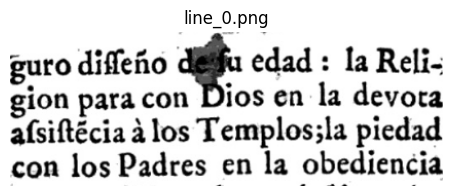

In [19]:
import os
import matplotlib.pyplot as plt
from PIL import Image

def display_line_images(folder_path="/kaggle/working/line_output"):
    # List all PNG files starting with "line_"
    image_files = sorted([
        f for f in os.listdir(folder_path) 
        if f.startswith("line_") and f.endswith(".png")
    ])
    
    # Display each image
    for img_file in image_files:
        img_path = os.path.join(folder_path, img_file)
        img = Image.open(img_path)
        
        plt.figure(figsize=(6, 2))
        plt.imshow(img)
        plt.axis("off")
        plt.title(img_file)
        plt.show()

# Example usage
display_line_images("/kaggle/working/line_output")


Detected line image files:
['line_0.png', 'line_1.png', 'line_2.png', 'line_3.png']


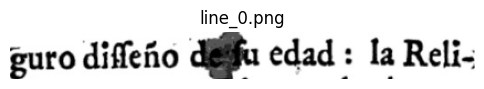

OCR for line_0.png: guro disleño de su edad. la Rei


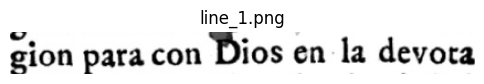

OCR for line_1.png: gion para con Dios en la de vaca


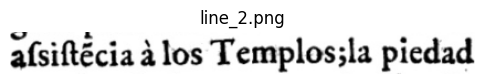

OCR for line_2.png: a la Isilecia a los Templos, la piedad


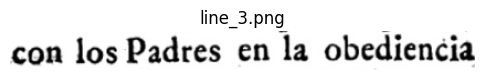

OCR for line_3.png: con los Padres en la obedientia

Final OCR Paragraph:
guro disleño de su edad. la Rei
gion para con Dios en la de vaca
a la Isilecia a los Templos, la piedad
con los Padres en la obedientia


In [ ]:

folder_path = "/kaggle/working/line_output"

# List and sort the image filenames based on the number in "line_#.png"
image_files = sorted(
    [f for f in os.listdir(folder_path) if re.match(r"line_\d+\.png", f)],
    key=lambda x: int(re.search(r"\d+", x).group())
)

print("Detected line image files:")
print(image_files)





# OCR each line image and collect the text
lines_text = []
for img_file in image_files:
    img_path = os.path.join(folder_path, img_file)
    img = Image.open(img_path).convert("RGB")  # Convert to RGB if necessary

    # Optionally display the image
    plt.figure(figsize=(6, 2))
    plt.imshow(img)
    plt.axis("off")
    plt.title(img_file)
    plt.show()

    # Preprocess the image
    inputs = processor(img, return_tensors="pt")
    pixel_values = inputs.pixel_values.to(device)

    # Generate prediction (adjust parameters if needed)
    generated_ids = model.generate(pixel_values, max_new_tokens=128, num_beams=5, early_stopping=True)
    line_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True).strip()

    print(f"OCR for {img_file}: {line_text}")
    lines_text.append(line_text)

# Join all the line texts into a single paragraph (with newlines or spaces)
paragraph = "\n".join(lines_text)

print("\nFinal OCR Paragraph:")
print(paragraph)



📄 Processing page 1


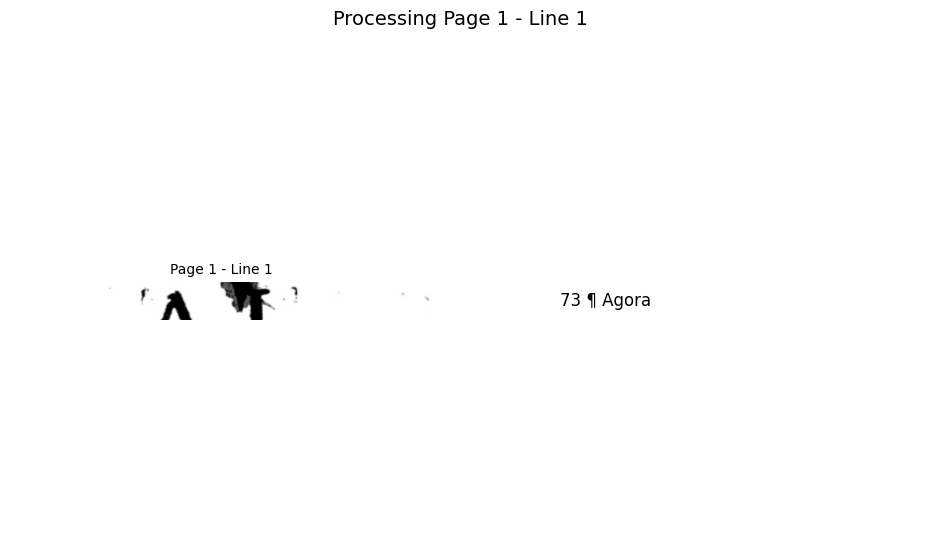

  Line 1: 73 ¶ Agora


<Figure size 640x480 with 0 Axes>

  Line 2: A L


<Figure size 640x480 with 0 Axes>

  Line 3: En finiramente A mal bō


<Figure size 640x480 with 0 Axes>

  Line 4: 73 ¶ Agora de la


<Figure size 640x480 with 0 Axes>

  Line 5: Nino pesus.

📄 Processing page 2


<Figure size 640x480 with 0 Axes>

  Line 1: Vos, Dulcisimo Niño


<Figure size 640x480 with 0 Axes>

  Line 2: JEsos, que no solo oso


<Figure size 640x480 with 0 Axes>

  Line 3: dignasteis de llamarōs


<Figure size 640x480 with 0 Axes>

  Line 4: Doctor de los Niños,

📄 Processing page 3


<Figure size 640x480 with 0 Axes>

  Line 1: flfino tambien de alsid-


<Figure size 640x480 with 0 Axes>

  Line 2: rir como Nuño entre los Doctors,


<Figure size 640x480 with 0 Axes>

  Line 3: de consagra humilde esta pequeña


<Figure size 640x480 with 0 Axes>

  Line 4: Inferuccion de los Nifos. Es assi,

📄 Processing page 4


<Figure size 640x480 with 0 Axes>

  Line 1: que ella cambien le dirige á la ju


<Figure size 640x480 with 0 Axes>

  Line 2: vencud, pero a esta, como recuer -


<Figure size 640x480 with 0 Axes>

  Line 3: do de lo que aprendio, a los Ni-


<Figure size 640x480 with 0 Axes>

  Line 4: chos, como precila explicacion de

📄 Processing page 5


<Figure size 640x480 with 0 Axes>

  Line 1: lo que de ben estudiar. Por este lo


<Figure size 640x480 with 0 Axes>

  Line 2: despero Ninos, que con fijas por


<Figure size 640x480 with 0 Axes>

  Line 3: educacion de vuestra Compañia,

📄 Processing page 6


<Figure size 640x480 with 0 Axes>

  Line 1: lo es mucho mas. En Vos, Dini


<Figure size 640x480 with 0 Axes>

  Line 2: no Exemplar de todas las virea -


<Figure size 640x480 with 0 Axes>

  Line 3: des, tienen abreviado el mas le


<Figure size 640x480 with 0 Axes>

  Line 4: 73 ¶ De ouo

📄 Processing page 7


<Figure size 640x480 with 0 Axes>

  Line 1: guro disleño de su edad. la Rei


<Figure size 640x480 with 0 Axes>

  Line 2: gion para con Dios en la de vaca


<Figure size 640x480 with 0 Axes>

  Line 3: a la Isilecia a los Templos, la piedad


<Figure size 640x480 with 0 Axes>

  Line 4: con los Padres en la obedientia

📄 Processing page 8


<Figure size 640x480 with 0 Axes>

  Line 1: mas rendida, & la modestia, y de


<Figure size 640x480 with 0 Axes>

  Line 2: deo de saber, con los mayores,


<Figure size 640x480 with 0 Axes>

  Line 3: gustando mas de Or, y pregun.


<Figure size 640x480 with 0 Axes>

  Line 4: rar, que de de finir, y relolver. Bien

📄 Processing page 9


<Figure size 640x480 with 0 Axes>

  Line 1: que esto en vuestra infinita sabi-


<Figure size 640x480 with 0 Axes>

  Line 2: duria fue Soberana dignacion, y


<Figure size 640x480 with 0 Axes>

  Line 3: en la natural Ignorancia de los


<Figure size 640x480 with 0 Axes>

  Line 4: Nilios es indispendable recelsi-

📄 Processing page 10


<Figure size 640x480 with 0 Axes>

  Line 1: dad. E el reina rei don siempe


<Figure size 640x480 with 0 Axes>

  Line 2: eNi tienen solamente en Vos


<Figure size 640x480 with 0 Axes>

  Line 3: el diseno, la lar, y el exemplo,


<Figure size 640x480 with 0 Axes>

  Line 4: dino tambien el amor, y protec -

📄 Processing page 11


<Figure size 640x480 with 0 Axes>

  Line 1: cion. Vos, como fingular Maes


<Figure size 640x480 with 0 Axes>

  Line 2: tro de los Niños, les dais enten-


<Figure size 640x480 with 0 Axes>

  Line 3: dimiento, y comunicais la sabi-


<Figure size 640x480 with 0 Axes>

  Line 4: doria Vos les prometeis el Reyno

📄 Processing page 12


<Figure size 640x480 with 0 Axes>

  Line 1: de los Cielos, yos indignais con


<Figure size 640x480 with 0 Axes>

  Line 2: quien les aparta de Vos, y les


<Figure size 640x480 with 0 Axes>

  Line 3: proponais por normal del con-


<Figure size 640x480 with 0 Axes>

  Line 4: dor, ingoencia, y christiana mu

📄 Processing page 13


<Figure size 640x480 with 0 Axes>

  Line 1: no pudo explicarle mas tierno, y


<Figure size 640x480 with 0 Axes>

  Line 2: liberal con los Niños, pues no


<Figure size 640x480 with 0 Axes>

  Line 3: contenço de echarles vuefras dixo


<Figure size 640x480 with 0 Axes>

  Line 4: Alfonso -

📄 Processing page 14


<Figure size 640x480 with 0 Axes>

  Line 1: divinas bendiciones, les misleis


<Figure size 640x480 with 0 Axes>

  Line 2: ña vnestro la grado pecho con lna


<Figure size 640x480 with 0 Axes>

  Line 3: missimos abraros, Dichola edad, A


<Figure size 640x480 with 0 Axes>

  Line 4: que es merecio can regalados ca

📄 Processing page 15


<Figure size 640x480 with 0 Axes>

  Line 1: y de Aquel


<Figure size 640x480 with 0 Axes>

  Line 2: Alfonso -


<Figure size 640x480 with 0 Axes>

  Line 3: y pues en la celestial Jerusalem


<Figure size 640x480 with 0 Axes>

  Line 4: salen no ha mudado de condicion


<Figure size 640x480 with 0 Axes>

  Line 5: vuestra Beniguidad, proleguid,

📄 Processing page 16


<Figure size 640x480 with 0 Axes>

  Line 1: do Niño tierno, y Dios Eterno,


<Figure size 640x480 with 0 Axes>

  Line 2: proleguid en bendecirles, y favo -


<Figure size 640x480 with 0 Axes>

  Line 3: recerles. Sean tan fervorio la men


<Figure size 640x480 with 0 Axes>

  Line 4: te de vocos de vuestra Admirable

📄 Processing page 17


<Figure size 640x480 with 0 Axes>

  Line 1: tos, que no entra vuestra sabi-


<Figure size 640x480 with 0 Axes>

  Line 2: daria, donde no ay mucha pure.


<Figure size 640x480 with 0 Axes>

  Line 3: era de conciencia. Ciercan en


<Figure size 640x480 with 0 Axes>

  Line 4: venestro santo temor, y amor, co-

📄 Processing page 18


<Figure size 640x480 with 0 Axes>

  Line 1: como en los años, y mucho mas


<Figure size 640x480 with 0 Axes>

  Line 2: Adelanteñle en la virtud, como


<Figure size 640x480 with 0 Axes>

  Line 3: en las letras, y mucho mas, haf-


<Figure size 640x480 with 0 Axes>

  Line 4: tra que lleguen, por vuestra imi-

📄 Processing page 19


<Figure size 640x480 with 0 Axes>

  Line 1: Alfonso -


<Figure size 640x480 with 0 Axes>

  Line 2: tacion, a ser varones perfectos,


<Figure size 640x480 with 0 Axes>

  Line 3: y con su mados, agradables a


<Figure size 640x480 with 0 Axes>

  Line 4: muestros ojos, y provechosos a


<Figure size 640x480 with 0 Axes>

  Line 5: la Republica, que libra casi co

📄 Processing page 20


<Figure size 640x480 with 0 Axes>

  Line 1: da su feliridad en la acercada


<Figure size 640x480 with 0 Axes>

  Line 2: 63 ¶ 148 ¶

📄 Processing page 21


<Figure size 640x480 with 0 Axes>

  Line 1: criarra de la Niñor. Assi leal


<Figure size 640x480 with 0 Axes>

  Line 2: Divinifsimo Niño, por vuestra


<Figure size 640x480 with 0 Axes>

  Line 3: gracia, assi lea, á vuestra mas


<Figure size 640x480 with 0 Axes>

  Line 4: y or gloria, Amen,

📄 Processing page 22


<Figure size 640x480 with 0 Axes>

  Line 1: E el Osorio de De Compañia de fizorio, el casa


<Figure size 640x480 with 0 Axes>

  Line 2: E por ouo fue los Theodos de Coronningados

📄 Processing page 23


<Figure size 640x480 with 0 Axes>

  Line 1: gel, y Barcelona, etc.


<Figure size 640x480 with 0 Axes>

  Line 2: Don sieta el rei don dixo

📄 Processing page 24


<Figure size 640x480 with 0 Axes>

  Line 1: Alfonso alfonso a la tierra


<Figure size 640x480 with 0 Axes>

  Line 2: Vicaidad En el su sañor de la su dio qe señor


<Figure size 640x480 with 0 Axes>

  Line 3: D. Balthafar de Baltero y Lledo, Obispo


<Figure size 640x480 with 0 Axes>

  Line 4: de Gerona, del Consejo de su Magestad, de ca


<Figure size 640x480 with 0 Axes>

The channel dimension is ambiguous. Got image shape (1, 543, 3). Assuming channels are the first dimension.


  Line 5: He visto en librio, cuyo circulo es. Ensi

📄 Processing page 25
  Error processing line 1


<Figure size 640x480 with 0 Axes>

  Line 2: truccion de Christiana, y Politics Cortesay


<Figure size 640x480 with 0 Axes>

  Line 3: nia, etc. Su Author D. Eanto Agustin de


<Figure size 640x480 with 0 Axes>

  Line 4: Buendia, Colegial que fue en el Imperial


<Figure size 640x480 with 0 Axes>

  Line 5: de Cordellas, sec. Y brevemente digos


<Figure size 640x480 with 0 Axes>

  Line 6: no solo que nada contiene contra la Fe, Vi

📄 Processing page 26


<Figure size 640x480 with 0 Axes>

  Line 1: buenas columbres, sino que muy aceno


<Figure size 640x480 with 0 Axes>

  Line 2: el Author con entrambas, describe, y en


<Figure size 640x480 with 0 Axes>

  Line 3: leha tan cuita, y discreteta la Virtud, co -


<Figure size 640x480 with 0 Axes>

  Line 4: mo lanca la Policia, y Urbandad. Los


<Figure size 640x480 with 0 Axes>

  Line 5: señoricos, que le criaron con estos do-

📄 Processing page 27


<Figure size 640x480 with 0 Axes>

  Line 1: cumenços, mereceran, quando hombres,


<Figure size 640x480 with 0 Axes>

  Line 2: a ver nacido señores. Porque no solo la


<Figure size 640x480 with 0 Axes>

  Line 3: bran ser Caballeros, fino tambien á los


<Figure size 640x480 with 0 Axes>

  Line 4: Alfonso -

📄 Processing page 28


<Figure size 640x480 with 0 Axes>

  Line 1: Caballero muy señorio, que codo lo, en el


<Figure size 640x480 with 0 Axes>

  Line 2: rece el Correlano Zelo del Author muchas


<Figure size 640x480 with 0 Axes>

The channel dimension is ambiguous. Got image shape (3, 538, 3). Assuming channels are the first dimension.


  Line 3: gracias de quantos le interellan en tan

📄 Processing page 29


<Figure size 640x480 with 0 Axes>

  Line 1: Alfonso


<Figure size 640x480 with 0 Axes>

  Line 2: primorola, como recellaria educacion


<Figure size 640x480 with 0 Axes>

  Line 3: de la primera edad de los Nobles; de cuē


<Figure size 640x480 with 0 Axes>

  Line 4: yo acierto se derivala primera orlidad,


<Figure size 640x480 with 0 Axes>

  Line 5: y de coro a la Republica. Assi lo fien


<Figure size 640x480 with 0 Axes>

  Line 6: to, salvo, sec. En este Colegio de San

📄 Processing page 30


<Figure size 640x480 with 0 Axes>

  Line 1: Martin de la Compañia de Jesus de Gero -


<Figure size 640x480 with 0 Axes>

  Line 2: na, a vs. de Julio de 1740.


<Figure size 640x480 with 0 Axes>

  Line 3: Antonio Godornis, de la


<Figure size 640x480 with 0 Axes>

  Line 4: 232 Compañia de Fesus.

📄 Processing page 31


<Figure size 640x480 with 0 Axes>

  Line 1: Dle vs. Fulli,. 148. ¶.


<Figure size 640x480 with 0 Axes>

  Line 2: Amprimatur


<Figure size 640x480 with 0 Axes>

  Line 3: De Bostero Vie. Gen. E Offis.

📄 Processing page 32


<Figure size 640x480 with 0 Axes>

  Line 1: Censora del R. P. mariano al bra


<Figure size 640x480 with 0 Axes>

  Line 2: rich de la Compañia de Fesus, Cathedral


<Figure size 640x480 with 0 Axes>

  Line 3: tico antes de Theologicia en el Colegio de


<Figure size 640x480 with 0 Axes>

  Line 4: Borcelona, ( oy Prefecto de sus E fu dios

📄 Processing page 33


<Figure size 640x480 with 0 Axes>

  Line 1: Rotor que fue del Colegio de Cordellas, y


<Figure size 640x480 with 0 Axes>

  Line 2: de Gerona, Calificador del Santo Osicio,


<Figure size 640x480 with 0 Axes>

  Line 3: Examinador Syndal de muchos Obispo.


<Figure size 640x480 with 0 Axes>

  Line 4: los dos oyo. e los moros cauieron

📄 Processing page 34


<Figure size 640x480 with 0 Axes>

  Line 1: M. P. S.


<Figure size 640x480 with 0 Axes>

  Line 2: dE orden de V. A he visto el librio //


<Figure size 640x480 with 0 Axes>

  Line 3: L que con el titulo de Politics, y Chris.


<Figure size 640x480 with 0 Axes>

  Line 4: tiana Cortesania, etc. de lea lacar a lue el

📄 Processing page 35


<Figure size 640x480 with 0 Axes>

  Line 1: Alfonso a qe moros e toledo de los de los de


<Figure size 640x480 with 0 Axes>

  Line 2: señor D. Fanto Agullin de Buendia, pa


<Figure size 640x480 with 0 Axes>

  Line 3: ra darle a todos con el concierto, que prele


<Figure size 640x480 with 0 Axes>

  Line 4: cribe para las operaciones, que cada umo


<Figure size 640x480 with 0 Axes>

  Line 5: de he practicar, desde el officimiento de

📄 Processing page 36


<Figure size 640x480 with 0 Axes>

  Line 1: pus. Perduciera qe de los el rei dixoles de


<Figure size 640x480 with 0 Axes>

  Line 2: las obras por la mañana, hasta el examen


<Figure size 640x480 with 0 Axes>

  Line 3: de la conciencia, Ultima diligentia, que


<Figure size 640x480 with 0 Axes>

  Line 4: de be cerrar nuestras carcas, antes de con -


<Figure size 640x480 with 0 Axes>

  Line 5: ceder al cuerpo el debido descaño, para

📄 Processing page 37


<Figure size 640x480 with 0 Axes>

  Line 1: tomarnos diariameme cuenta de todas las


<Figure size 640x480 with 0 Axes>

  Line 2: partidas del cargo, y del cargo, como la

📄 Processing page 38


<Figure size 640x480 with 0 Axes>

  Line 1: hemos de dar en otro mas severo cribuā


<Figure size 640x480 with 0 Axes>

  Line 2: nal. Quien a este pequeño volumen mī


<Figure size 640x480 with 0 Axes>

  Line 3: diere por el cuerpo, no le dara la esima


<Figure size 640x480 with 0 Axes>

  Line 4: cion, que le merece: pero quien a tendie

📄 Processing page 39


<Figure size 640x480 with 0 Axes>

  Line 1: rre a la mucha alma, que encierra, forma


<Figure size 640x480 with 0 Axes>

  Line 2: ria el debido concepto de su preciobdad.


<Figure size 640x480 with 0 Axes>

  Line 3: Colas ay, que se celebran por lo a gigan -


<Figure size 640x480 with 0 Axes>

The channel dimension is ambiguous. Got image shape (3, 538, 3). Assuming channels are the first dimension.


  Line 4: tado, como el Cololo. y las ay tambien,

📄 Processing page 40


<Figure size 640x480 with 0 Axes>

  Line 1: Alfonso -


<Figure size 640x480 with 0 Axes>

  Line 2: como el Nuño de Bruco, que tuyieron


<Figure size 640x480 with 0 Axes>

  Line 3: Eugal aplado, por auer redicido casi a


<Figure size 640x480 with 0 Axes>

  Line 4: puntos indivisibles todo el arcilicio de


<Figure size 640x480 with 0 Axes>

  Line 5: cosas grandes. Assi ay Authors, que

📄 Processing page 41


<Figure size 640x480 with 0 Axes>

  Line 1: y de los Aquel pueblos y los moros


<Figure size 640x480 with 0 Axes>

  Line 2: chan llenado de libros grandes los estan-


<Figure size 640x480 with 0 Axes>

  Line 3: res, acredicandole hasta con el oro, que


<Figure size 640x480 with 0 Axes>

  Line 4: lace en sus cubiertas. otros, con no


<Figure size 640x480 with 0 Axes>

  Line 5: menor a cierto, han dado a lur libritos mas

📄 Processing page 42


<Figure size 640x480 with 0 Axes>

  Line 1: familiares, que le dexan trarar a todas


<Figure size 640x480 with 0 Axes>

  Line 2: moras, compañeros imperables de sus


<Figure size 640x480 with 0 Axes>

  Line 3: dueños, los quales ya en las cubiertas


<Figure size 640x480 with 0 Axes>

  Line 4: llevan aquella inscription, o el ogio, que

📄 Processing page 43


<Figure size 640x480 with 0 Axes>

  Line 1: dio el acumino lo Marcial a sus escritos.


<Figure size 640x480 with 0 Axes>

  Line 2: Me manus una capit. Y como feria ne


<Figure size 640x480 with 0 Axes>

  Line 3: cedad, querer eltimar el valor de el dia


<Figure size 640x480 with 0 Axes>

  Line 4: mente, antes por la grandera, que no

📄 Processing page 44


<Figure size 640x480 with 0 Axes>

  Line 1: y el rei don siempe por el pueblo y


<Figure size 640x480 with 0 Axes>

  Line 2: tiene, que por los fondos, con que le


<Figure size 640x480 with 0 Axes>

  Line 3: huerta al sol los rayos en la precida bri-


<Figure size 640x480 with 0 Axes>

  Line 4: llanter de sus reflexos. Assi lo seria no


<Figure size 640x480 with 0 Axes>

The channel dimension is ambiguous. Got image shape (3, 536, 3). Assuming channels are the first dimension.


  Line 5: colocar entre las joyas de mayor precio


<Figure size 640x480 with 0 Axes>

  Line 6: Alfonso -

📄 Processing page 45

📄 Processing page 46

📄 Processing page 47

📄 Processing page 48


<Figure size 640x480 with 0 Axes>

  Line 1: pre, de ccc. Barcelona, y Junio 14. de.178


<Figure size 640x480 with 0 Axes>

  Line 2: l M Mariano Alberich de la


<Figure size 640x480 with 0 Axes>

  Line 3: 232 Compañia de fesus.

📄 Processing page 49


<Figure size 640x480 with 0 Axes>

  Line 1: auna del Privilegio.


<Figure size 640x480 with 0 Axes>

  Line 2: Elfonso dio Aglesia de la Maglesia Don

📄 Processing page 50


<Figure size 640x480 with 0 Axes>

  Line 1: petiridad Con el suffruccion de Christiania y


<Figure size 640x480 with 0 Axes>

  Line 2: te concta de su original. Madrid, y Julio


<Figure size 640x480 with 0 Axes>

  Line 3: ña 8 de r740. e dixo a

📄 Processing page 51


<Figure size 640x480 with 0 Axes>

  Line 1: d DePro Manuel de Contreras.


<Figure size 640x480 with 0 Axes>

  Line 2: y el rei don siempre el rei don siempre el rei don siempe


<Figure size 640x480 with 0 Axes>

  Line 3: 63 ¶ T A S A Agora


<Figure size 640x480 with 0 Axes>

  Line 4: T Alaron los Señores del Consejo este


<Figure size 640x480 with 0 Axes>

  Line 5: s Libro,inticolado. Inferuccion de

📄 Processing page 52


<Figure size 640x480 with 0 Axes>

  Line 1: Christiana, y Politics Cortesania, a leis


<Figure size 640x480 with 0 Axes>

  Line 2: mugaredis de dios llego doño reina de dios


<Figure size 640x480 with 0 Axes>

  Line 3: d De Pedro Manuel de Contreras.

📄 Processing page 53


<Figure size 640x480 with 0 Axes>

  Line 1: el rei don sancho e el rei don sancho el rei don grā


<Figure size 640x480 with 0 Axes>

  Line 2: Pee de Erraras.


<Figure size 640x480 with 0 Axes>

  Line 3: sse libro, inclado. Instruction de


<Figure size 640x480 with 0 Axes>

  Line 4: Christiana, y Politics Cortesania, cor-

📄 Processing page 54


<Figure size 640x480 with 0 Axes>

  Line 1: responde en rodo con su original. Madrid


<Figure size 640x480 with 0 Axes>

  Line 2: ña ro, de Agollo de 1740. E

📄 Processing page 55


<Figure size 640x480 with 0 Axes>

  Line 1: Lis. Du Manuel Licardo de Ribera y


<Figure size 640x480 with 0 Axes>

  Line 2: Correct. Gen. por su Magestad.


<Figure size 640x480 with 0 Axes>

  Line 3: 50 ¶. Moña

📄 Processing page 56


<Figure size 640x480 with 0 Axes>

  Line 1: mo rivo del author, e razon


<Figure size 640x480 with 0 Axes>

  Line 2: 73 de la Obra. E el reino

📄 Processing page 57


<Figure size 640x480 with 0 Axes>

  Line 1: A de vocion, y afecto, que desde mis


<Figure size 640x480 with 0 Axes>

  Line 2: tiernos años professe a la Sagrada

📄 Processing page 58


<Figure size 640x480 with 0 Axes>

  Line 1: Religión de la Compañia de Jesus, y la


<Figure size 640x480 with 0 Axes>

  Line 2: professare eternamente, como hijo el mas


<Figure size 640x480 with 0 Axes>

  Line 3: re conocido a tan escogida Madre. e me


<Figure size 640x480 with 0 Axes>

  Line 4: obligo a el cririr, y dar a la Estampa esta

📄 Processing page 59


<Figure size 640x480 with 0 Axes>

  Line 1: Infinacion para lus señores Colegiales,


<Figure size 640x480 with 0 Axes>

  Line 2: sin que por esso le niegue a lervir a los de


<Figure size 640x480 with 0 Axes>

  Line 3: mas señoricos, que no lo fueren. Y aun


<Figure size 640x480 with 0 Axes>

  Line 4: que la Compañia, mas por su conocida

📄 Processing page 60


<Figure size 640x480 with 0 Axes>

  Line 1: erencion, que por el meriro, que yo no


<Figure size 640x480 with 0 Axes>

  Line 2: tiengo, recibira con gusto este mi oble.


<Figure size 640x480 with 0 Axes>

  Line 3: quio, todavia, por dirigirle al culciro


<Figure size 640x480 with 0 Axes>

  Line 4: de aquellas Plantas, que la Diving Pro-

📄 Processing page 61


<Figure size 640x480 with 0 Axes>

  Line 1: videncia, por medio del Gran Parianca


<Figure size 640x480 with 0 Axes>

  Line 2: Ignacio, fio al cuydado reloso de su de


<Figure size 640x480 with 0 Axes>

  Line 3: licada mano . se yo, y lo se muy bien, que


<Figure size 640x480 with 0 Axes>

  Line 4: le merecera esta Obrica la primera año

📄 Processing page 62


<Figure size 640x480 with 0 Axes>

  Line 1: bacion. e los moros


<Figure size 640x480 with 0 Axes>

  Line 2: m Juego, que nadie ignora, quanto


<Figure size 640x480 with 0 Axes>

  Line 3: rrabajo la Compañia en la criana de los


<Figure size 640x480 with 0 Axes>

  Line 4: minos en sus Colegios, tarca igualmente

📄 Processing page 63


<Figure size 640x480 with 0 Axes>

  Line 1: penola, que provechola, para guardarō


<Figure size 640x480 with 0 Axes>

  Line 2: des del mal, e infruirles en el bien, y que


<Figure size 640x480 with 0 Axes>

  Line 3: por esso les enseñalas buenas letras, para


<Figure size 640x480 with 0 Axes>

  Line 4: Alfonso -

Final OCR Results:
73 ¶ Agora
A L
En finiramente A mal bō
73 ¶ Agora de la
Nino pesus.

════════════════════════════════════════════════════════════ PAGE BREAK ════════════════════════════════════════════════════════════

Vos, Dulcisimo Niño
JEsos, que no solo oso
dignasteis de llamarōs
Doctor de los Niños,

════════════════════════════════════════════════════════════ PAGE BREAK ════════════════════════════════════════════════════════════

flfino tambien de alsid-
rir como Nuño entre los Doctors,
de consagra humilde esta pequeña
Inferuccion de los Nifos. Es assi,

════════════════════════════════════════════════════════════ PAGE BREAK ════════════════════════════════════════════════════════════

que ella cambien le dirige á la ju
vencud, pero a esta, como recuer -
do de lo que aprendio, a los Ni-
chos, como precila explicacion de

════════════════════════════════════════════════════════════ PAGE BREAK ════════════════════════════════════════════════════════════

lo

In [ ]:


def parse_folder_timestamp(folder_name):
    """Extract datetime from folder name"""
    match = re.match(r'Screenshot (\d{4}-\d{2}-\d{2}) at (\d{1,2})\.(\d{2})\.(\d{2}) ([AP]M)', folder_name)
    if not match:
        return datetime.max
    
    date_str, hour, minute, second, period = match.groups()
    time_str = f"{hour}:{minute}:{second} {period}"
    
    return datetime.strptime(f"{date_str} {time_str}", "%Y-%m-%d %I:%M:%S %p")

def process_directory(root_dir):
    all_text = []
    
    # Sort pages by timestamp
    page_folders = sorted(
        [f for f in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, f))],
        key=parse_folder_timestamp)
    
    # Setup display
    plt.ion()
    fig = plt.figure(figsize=(12, 6))
    
    for page_number, _ in enumerate(page_folders, 1):
        page_text = []
        line_files = sorted(
            [f for f in os.listdir(os.path.join(root_dir, page_folders[page_number-1])) 
             if re.match(r'line_\d+\.png', f)],
            key=lambda x: int(re.search(r'\d+', x).group()))
        
        print(f"\n📄 Processing page {page_number}")
        
        for line_idx, _ in enumerate(line_files, 1):
            try:
                # Image display
                img_path = os.path.join(root_dir, page_folders[page_number-1], f'line_{line_idx-1}.png')
                img = Image.open(img_path).convert("RGB")
                ax1 = fig.add_subplot(1, 2, 1)
                ax1.imshow(img)
                ax1.set_title(f"Page {page_number} - Line {line_idx}", fontsize=10)
                ax1.axis('off')
                
                # OCR processing
                inputs = processor(img, return_tensors="pt")
                pixel_values = inputs.pixel_values.to(device)
                
                generated_ids = model.generate(
                    pixel_values, 
                    max_new_tokens=128,
                    num_beams=5,
                    early_stopping=True)
                
                line_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True).strip()
                
                # Display result
                ax2 = fig.add_subplot(1, 2, 2)
                ax2.text(0.1, 0.5, line_text, fontsize=12, va='center')
                ax2.axis('off')
                
                plt.suptitle(f"Processing Page {page_number} - Line {line_idx}", fontsize=14)
                plt.draw()
                plt.pause(0.1)
                
                page_text.append(line_text)
                print(f"  Line {line_idx}: {line_text}")
                fig.clf()
                
            except Exception as e:
                print(f"  Error processing line {line_idx}")
                page_text.append("[OCR ERROR]")
                fig.clf()
        
        all_text.append("\n".join(page_text))
        all_text.append("\n" + "═"*60 + " PAGE BREAK " + "═"*60 + "\n")
    
    plt.ioff()
    plt.close()
    return "\n".join(all_text)

# Process and save
final_text = process_directory("/kaggle/working/line_output2")
print("\nFinal OCR Results:")
print(final_text)

with open("/kaggle/working/final_ocr_output.txt", "w") as f:
    f.write(final_text)

print("\nOCR results saved successfully")


📄 Processing page 1 (4 lines)


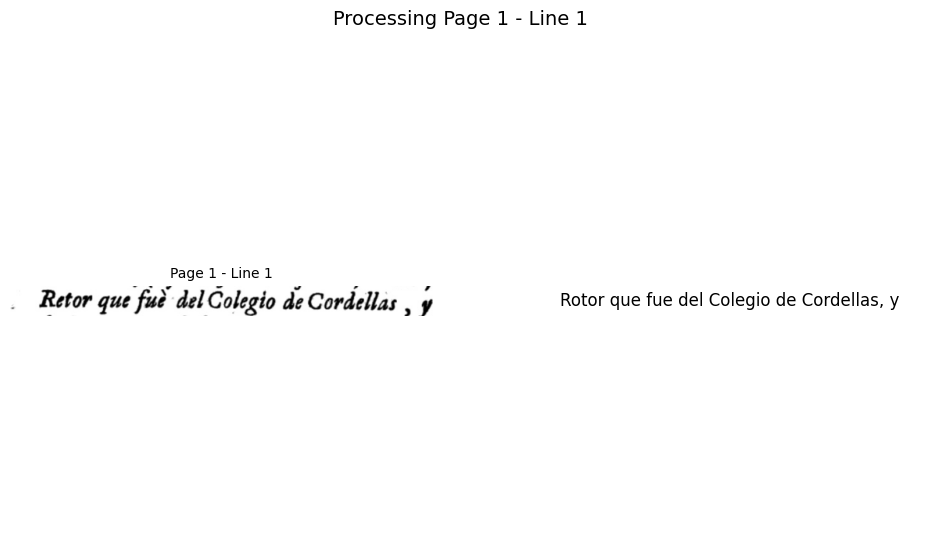

  Line 1: Rotor que fue del Colegio de Cordellas, y


<Figure size 640x480 with 0 Axes>

  Line 2: de Gerona, Calificador del Santo Osicio,


<Figure size 640x480 with 0 Axes>

  Line 3: Examinador Syndal de muchos Obispo.


<Figure size 640x480 with 0 Axes>

  Line 4: los dos oyo. e los moros cauieron

📄 Processing page 2 (4 lines)


<Figure size 640x480 with 0 Axes>

  Line 1: bacion. e los moros


<Figure size 640x480 with 0 Axes>

  Line 2: m Juego, que nadie ignora, quanto


<Figure size 640x480 with 0 Axes>

  Line 3: rrabajo la Compañia en la criana de los


<Figure size 640x480 with 0 Axes>

  Line 4: minos en sus Colegios, tarca igualmente

📄 Processing page 3 (5 lines)


<Figure size 640x480 with 0 Axes>

  Line 1: 73 ¶ Agora


<Figure size 640x480 with 0 Axes>

  Line 2: A L


<Figure size 640x480 with 0 Axes>

  Line 3: En finiramente A mal bō


<Figure size 640x480 with 0 Axes>

  Line 4: 73 ¶ Agora de la


<Figure size 640x480 with 0 Axes>

The channel dimension is ambiguous. Got image shape (3, 538, 3). Assuming channels are the first dimension.


  Line 5: Nino pesus.

📄 Processing page 4 (5 lines)


<Figure size 640x480 with 0 Axes>

  Line 1: Alfonso -


<Figure size 640x480 with 0 Axes>

  Line 2: como el Nuño de Bruco, que tuyieron


<Figure size 640x480 with 0 Axes>

  Line 3: Eugal aplado, por auer redicido casi a


<Figure size 640x480 with 0 Axes>

  Line 4: puntos indivisibles todo el arcilicio de


<Figure size 640x480 with 0 Axes>

  Line 5: cosas grandes. Assi ay Authors, que

📄 Processing page 5 (6 lines)


<Figure size 640x480 with 0 Axes>

  Line 1: y el rei don siempe por el pueblo y


<Figure size 640x480 with 0 Axes>

  Line 2: tiene, que por los fondos, con que le


<Figure size 640x480 with 0 Axes>

  Line 3: huerta al sol los rayos en la precida bri-


<Figure size 640x480 with 0 Axes>

  Line 4: llanter de sus reflexos. Assi lo seria no


<Figure size 640x480 with 0 Axes>

The channel dimension is ambiguous. Got image shape (3, 536, 3). Assuming channels are the first dimension.


  Line 5: colocar entre las joyas de mayor precio


<Figure size 640x480 with 0 Axes>

  Line 6: Alfonso -

📄 Processing page 6 (5 lines)


<Figure size 640x480 with 0 Axes>

  Line 1: pus. Perduciera qe de los el rei dixoles de


<Figure size 640x480 with 0 Axes>

  Line 2: las obras por la mañana, hasta el examen


<Figure size 640x480 with 0 Axes>

  Line 3: de la conciencia, Ultima diligentia, que


<Figure size 640x480 with 0 Axes>

  Line 4: de be cerrar nuestras carcas, antes de con -


<Figure size 640x480 with 0 Axes>

  Line 5: ceder al cuerpo el debido descaño, para

📄 Processing page 7 (0 lines)

📄 Processing page 8 (2 lines)


<Figure size 640x480 with 0 Axes>

  Line 1: gel, y Barcelona, etc.


<Figure size 640x480 with 0 Axes>

  Line 2: Don sieta el rei don dixo

📄 Processing page 9 (4 lines)


<Figure size 640x480 with 0 Axes>

  Line 1: rre a la mucha alma, que encierra, forma


<Figure size 640x480 with 0 Axes>

  Line 2: ria el debido concepto de su preciobdad.


<Figure size 640x480 with 0 Axes>

  Line 3: Colas ay, que se celebran por lo a gigan -


<Figure size 640x480 with 0 Axes>

  Line 4: tado, como el Cololo. y las ay tambien,

📄 Processing page 10 (5 lines)


<Figure size 640x480 with 0 Axes>

  Line 1: Alfonso -


<Figure size 640x480 with 0 Axes>

  Line 2: tacion, a ser varones perfectos,


<Figure size 640x480 with 0 Axes>

  Line 3: y con su mados, agradables a


<Figure size 640x480 with 0 Axes>

  Line 4: muestros ojos, y provechosos a


<Figure size 640x480 with 0 Axes>

  Line 5: la Republica, que libra casi co

📄 Processing page 11 (4 lines)


<Figure size 640x480 with 0 Axes>

  Line 1: que esto en vuestra infinita sabi-


<Figure size 640x480 with 0 Axes>

  Line 2: duria fue Soberana dignacion, y


<Figure size 640x480 with 0 Axes>

  Line 3: en la natural Ignorancia de los


<Figure size 640x480 with 0 Axes>

  Line 4: Nilios es indispendable recelsi-

📄 Processing page 12 (2 lines)


<Figure size 640x480 with 0 Axes>

  Line 1: A de vocion, y afecto, que desde mis


<Figure size 640x480 with 0 Axes>

  Line 2: tiernos años professe a la Sagrada

📄 Processing page 13 (4 lines)


<Figure size 640x480 with 0 Axes>

  Line 1: videncia, por medio del Gran Parianca


<Figure size 640x480 with 0 Axes>

  Line 2: Ignacio, fio al cuydado reloso de su de


<Figure size 640x480 with 0 Axes>

  Line 3: licada mano . se yo, y lo se muy bien, que


<Figure size 640x480 with 0 Axes>

  Line 4: le merecera esta Obrica la primera año

📄 Processing page 14 (0 lines)

📄 Processing page 15 (4 lines)


<Figure size 640x480 with 0 Axes>

  Line 1: erencion, que por el meriro, que yo no


<Figure size 640x480 with 0 Axes>

  Line 2: tiengo, recibira con gusto este mi oble.


<Figure size 640x480 with 0 Axes>

  Line 3: quio, todavia, por dirigirle al culciro


<Figure size 640x480 with 0 Axes>

  Line 4: de aquellas Plantas, que la Diving Pro-

📄 Processing page 16 (4 lines)


<Figure size 640x480 with 0 Axes>

  Line 1: Vos, Dulcisimo Niño


<Figure size 640x480 with 0 Axes>

  Line 2: JEsos, que no solo oso


<Figure size 640x480 with 0 Axes>

  Line 3: dignasteis de llamarōs


<Figure size 640x480 with 0 Axes>

  Line 4: Doctor de los Niños,

📄 Processing page 17 (4 lines)


<Figure size 640x480 with 0 Axes>

  Line 1: criarra de la Niñor. Assi leal


<Figure size 640x480 with 0 Axes>

  Line 2: Divinifsimo Niño, por vuestra


<Figure size 640x480 with 0 Axes>

  Line 3: gracia, assi lea, á vuestra mas


<Figure size 640x480 with 0 Axes>

  Line 4: y or gloria, Amen,

📄 Processing page 18 (4 lines)


<Figure size 640x480 with 0 Axes>

  Line 1: dio el acumino lo Marcial a sus escritos.


<Figure size 640x480 with 0 Axes>

  Line 2: Me manus una capit. Y como feria ne


<Figure size 640x480 with 0 Axes>

  Line 3: cedad, querer eltimar el valor de el dia


<Figure size 640x480 with 0 Axes>

  Line 4: mente, antes por la grandera, que no

📄 Processing page 19 (4 lines)


<Figure size 640x480 with 0 Axes>

  Line 1: hemos de dar en otro mas severo cribuā


<Figure size 640x480 with 0 Axes>

  Line 2: nal. Quien a este pequeño volumen mī


<Figure size 640x480 with 0 Axes>

  Line 3: diere por el cuerpo, no le dara la esima


<Figure size 640x480 with 0 Axes>

  Line 4: cion, que le merece: pero quien a tendie

📄 Processing page 20 (4 lines)


<Figure size 640x480 with 0 Axes>

  Line 1: Religión de la Compañia de Jesus, y la


<Figure size 640x480 with 0 Axes>

  Line 2: professare eternamente, como hijo el mas


<Figure size 640x480 with 0 Axes>

  Line 3: re conocido a tan escogida Madre. e me


<Figure size 640x480 with 0 Axes>

  Line 4: obligo a el cririr, y dar a la Estampa esta

📄 Processing page 21 (5 lines)


<Figure size 640x480 with 0 Axes>

  Line 1: y de Aquel


<Figure size 640x480 with 0 Axes>

  Line 2: Alfonso -


<Figure size 640x480 with 0 Axes>

  Line 3: y pues en la celestial Jerusalem


<Figure size 640x480 with 0 Axes>

  Line 4: salen no ha mudado de condicion


<Figure size 640x480 with 0 Axes>

  Line 5: vuestra Beniguidad, proleguid,

📄 Processing page 22 (4 lines)


<Figure size 640x480 with 0 Axes>

  Line 1: mas rendida, & la modestia, y de


<Figure size 640x480 with 0 Axes>

  Line 2: deo de saber, con los mayores,


<Figure size 640x480 with 0 Axes>

  Line 3: gustando mas de Or, y pregun.


<Figure size 640x480 with 0 Axes>

  Line 4: rar, que de de finir, y relolver. Bien

📄 Processing page 23 (2 lines)


<Figure size 640x480 with 0 Axes>

  Line 1: E el Osorio de De Compañia de fizorio, el casa


<Figure size 640x480 with 0 Axes>

  Line 2: E por ouo fue los Theodos de Coronningados

📄 Processing page 24 (5 lines)


<Figure size 640x480 with 0 Axes>

  Line 1: buenas columbres, sino que muy aceno


<Figure size 640x480 with 0 Axes>

  Line 2: el Author con entrambas, describe, y en


<Figure size 640x480 with 0 Axes>

  Line 3: leha tan cuita, y discreteta la Virtud, co -


<Figure size 640x480 with 0 Axes>

  Line 4: mo lanca la Policia, y Urbandad. Los


<Figure size 640x480 with 0 Axes>

  Line 5: señoricos, que le criaron con estos do-

📄 Processing page 25 (2 lines)


<Figure size 640x480 with 0 Axes>

  Line 1: responde en rodo con su original. Madrid


<Figure size 640x480 with 0 Axes>

  Line 2: ña ro, de Agollo de 1740. E

📄 Processing page 26 (4 lines)


<Figure size 640x480 with 0 Axes>

  Line 1: Infinacion para lus señores Colegiales,


<Figure size 640x480 with 0 Axes>

  Line 2: sin que por esso le niegue a lervir a los de


<Figure size 640x480 with 0 Axes>

  Line 3: mas señoricos, que no lo fueren. Y aun


<Figure size 640x480 with 0 Axes>

  Line 4: que la Compañia, mas por su conocida

📄 Processing page 27 (3 lines)


<Figure size 640x480 with 0 Axes>

  Line 1: Dle vs. Fulli,. 148. ¶.


<Figure size 640x480 with 0 Axes>

  Line 2: Amprimatur


<Figure size 640x480 with 0 Axes>

  Line 3: De Bostero Vie. Gen. E Offis.

📄 Processing page 28 (3 lines)


<Figure size 640x480 with 0 Axes>

  Line 1: Caballero muy señorio, que codo lo, en el


<Figure size 640x480 with 0 Axes>

  Line 2: rece el Correlano Zelo del Author muchas


<Figure size 640x480 with 0 Axes>

  Line 3: gracias de quantos le interellan en tan

📄 Processing page 29 (4 lines)


<Figure size 640x480 with 0 Axes>

  Line 1: cion. Vos, como fingular Maes


<Figure size 640x480 with 0 Axes>

  Line 2: tro de los Niños, les dais enten-


<Figure size 640x480 with 0 Axes>

  Line 3: dimiento, y comunicais la sabi-


<Figure size 640x480 with 0 Axes>

  Line 4: doria Vos les prometeis el Reyno

📄 Processing page 30 (4 lines)


<Figure size 640x480 with 0 Axes>

  Line 1: tos, que no entra vuestra sabi-


<Figure size 640x480 with 0 Axes>

  Line 2: daria, donde no ay mucha pure.


<Figure size 640x480 with 0 Axes>

  Line 3: era de conciencia. Ciercan en


<Figure size 640x480 with 0 Axes>

  Line 4: venestro santo temor, y amor, co-

📄 Processing page 31 (3 lines)


<Figure size 640x480 with 0 Axes>

  Line 1: petiridad Con el suffruccion de Christiania y


<Figure size 640x480 with 0 Axes>

  Line 2: te concta de su original. Madrid, y Julio


<Figure size 640x480 with 0 Axes>

  Line 3: ña 8 de r740. e dixo a

📄 Processing page 32 (4 lines)


<Figure size 640x480 with 0 Axes>

  Line 1: penola, que provechola, para guardarō


<Figure size 640x480 with 0 Axes>

  Line 2: des del mal, e infruirles en el bien, y que


<Figure size 640x480 with 0 Axes>

  Line 3: por esso les enseñalas buenas letras, para


<Figure size 640x480 with 0 Axes>

  Line 4: Alfonso -

📄 Processing page 33 (4 lines)


<Figure size 640x480 with 0 Axes>

  Line 1: dad. E el reina rei don siempe


<Figure size 640x480 with 0 Axes>

  Line 2: eNi tienen solamente en Vos


<Figure size 640x480 with 0 Axes>

  Line 3: el diseno, la lar, y el exemplo,


<Figure size 640x480 with 0 Axes>

  Line 4: dino tambien el amor, y protec -

📄 Processing page 34 (2 lines)


<Figure size 640x480 with 0 Axes>

  Line 1: tomarnos diariameme cuenta de todas las


<Figure size 640x480 with 0 Axes>

  Line 2: partidas del cargo, y del cargo, como la

📄 Processing page 35 (4 lines)


<Figure size 640x480 with 0 Axes>

  Line 1: no pudo explicarle mas tierno, y


<Figure size 640x480 with 0 Axes>

  Line 2: liberal con los Niños, pues no


<Figure size 640x480 with 0 Axes>

  Line 3: contenço de echarles vuefras dixo


<Figure size 640x480 with 0 Axes>

  Line 4: Alfonso -

📄 Processing page 36 (4 lines)


<Figure size 640x480 with 0 Axes>

  Line 1: M. P. S.


<Figure size 640x480 with 0 Axes>

  Line 2: dE orden de V. A he visto el librio //


<Figure size 640x480 with 0 Axes>

  Line 3: L que con el titulo de Politics, y Chris.


<Figure size 640x480 with 0 Axes>

  Line 4: tiana Cortesania, etc. de lea lacar a lue el

📄 Processing page 37 (3 lines)


<Figure size 640x480 with 0 Axes>

  Line 1: pre, de ccc. Barcelona, y Junio 14. de.178


<Figure size 640x480 with 0 Axes>

  Line 2: l M Mariano Alberich de la


<Figure size 640x480 with 0 Axes>

  Line 3: 232 Compañia de fesus.

📄 Processing page 38 (4 lines)


<Figure size 640x480 with 0 Axes>

  Line 1: flfino tambien de alsid-


<Figure size 640x480 with 0 Axes>

  Line 2: rir como Nuño entre los Doctors,


<Figure size 640x480 with 0 Axes>

  Line 3: de consagra humilde esta pequeña


<Figure size 640x480 with 0 Axes>

  Line 4: Inferuccion de los Nifos. Es assi,

📄 Processing page 39 (4 lines)


<Figure size 640x480 with 0 Axes>

  Line 1: de los Cielos, yos indignais con


<Figure size 640x480 with 0 Axes>

  Line 2: quien les aparta de Vos, y les


<Figure size 640x480 with 0 Axes>

  Line 3: proponais por normal del con-


<Figure size 640x480 with 0 Axes>

  Line 4: dor, ingoencia, y christiana mu

📄 Processing page 40 (2 lines)


<Figure size 640x480 with 0 Axes>

  Line 1: auna del Privilegio.


<Figure size 640x480 with 0 Axes>

  Line 2: Elfonso dio Aglesia de la Maglesia Don

📄 Processing page 41 (4 lines)


<Figure size 640x480 with 0 Axes>

  Line 1: Censora del R. P. mariano al bra


<Figure size 640x480 with 0 Axes>

  Line 2: rich de la Compañia de Fesus, Cathedral


<Figure size 640x480 with 0 Axes>

  Line 3: tico antes de Theologicia en el Colegio de


<Figure size 640x480 with 0 Axes>

  Line 4: Borcelona, ( oy Prefecto de sus E fu dios

📄 Processing page 42 (5 lines)


<Figure size 640x480 with 0 Axes>

  Line 1: Alfonso alfonso a la tierra


<Figure size 640x480 with 0 Axes>

  Line 2: Vicaidad En el su sañor de la su dio qe señor


<Figure size 640x480 with 0 Axes>

  Line 3: D. Balthafar de Baltero y Lledo, Obispo


<Figure size 640x480 with 0 Axes>

  Line 4: de Gerona, del Consejo de su Magestad, de ca


<Figure size 640x480 with 0 Axes>

  Line 5: He visto en librio, cuyo circulo es. Ensi

📄 Processing page 43 (3 lines)


<Figure size 640x480 with 0 Axes>

  Line 1: Christiana, y Politics Cortesania, a leis


<Figure size 640x480 with 0 Axes>

  Line 2: mugaredis de dios llego doño reina de dios


<Figure size 640x480 with 0 Axes>

  Line 3: d De Pedro Manuel de Contreras.

📄 Processing page 44 (4 lines)


<Figure size 640x480 with 0 Axes>

  Line 1: el rei don sancho e el rei don sancho el rei don grā


<Figure size 640x480 with 0 Axes>

  Line 2: Pee de Erraras.


<Figure size 640x480 with 0 Axes>

  Line 3: sse libro, inclado. Instruction de


<Figure size 640x480 with 0 Axes>

  Line 4: Christiana, y Politics Cortesania, cor-

📄 Processing page 45 (4 lines)


<Figure size 640x480 with 0 Axes>

  Line 1: familiares, que le dexan trarar a todas


<Figure size 640x480 with 0 Axes>

  Line 2: moras, compañeros imperables de sus


<Figure size 640x480 with 0 Axes>

  Line 3: dueños, los quales ya en las cubiertas


<Figure size 640x480 with 0 Axes>

  Line 4: llevan aquella inscription, o el ogio, que

📄 Processing page 46 (4 lines)


<Figure size 640x480 with 0 Axes>

  Line 1: cumenços, mereceran, quando hombres,


<Figure size 640x480 with 0 Axes>

  Line 2: a ver nacido señores. Porque no solo la


<Figure size 640x480 with 0 Axes>

  Line 3: bran ser Caballeros, fino tambien á los


<Figure size 640x480 with 0 Axes>

  Line 4: Alfonso -

📄 Processing page 47 (3 lines)


<Figure size 640x480 with 0 Axes>

  Line 1: lo que de ben estudiar. Por este lo


<Figure size 640x480 with 0 Axes>

  Line 2: despero Ninos, que con fijas por


<Figure size 640x480 with 0 Axes>

  Line 3: educacion de vuestra Compañia,

📄 Processing page 48 (4 lines)


<Figure size 640x480 with 0 Axes>

  Line 1: que ella cambien le dirige á la ju


<Figure size 640x480 with 0 Axes>

  Line 2: vencud, pero a esta, como recuer -


<Figure size 640x480 with 0 Axes>

  Line 3: do de lo que aprendio, a los Ni-


<Figure size 640x480 with 0 Axes>

  Line 4: chos, como precila explicacion de

📄 Processing page 49 (2 lines)


<Figure size 640x480 with 0 Axes>

  Line 1: da su feliridad en la acercada


<Figure size 640x480 with 0 Axes>

  Line 2: 63 ¶ 148 ¶

📄 Processing page 50 (2 lines)


<Figure size 640x480 with 0 Axes>

  Line 1: mo rivo del author, e razon


<Figure size 640x480 with 0 Axes>

  Line 2: 73 de la Obra. E el reino

📄 Processing page 51 (4 lines)


<Figure size 640x480 with 0 Axes>

  Line 1: do Niño tierno, y Dios Eterno,


<Figure size 640x480 with 0 Axes>

  Line 2: proleguid en bendecirles, y favo -


<Figure size 640x480 with 0 Axes>

  Line 3: recerles. Sean tan fervorio la men


<Figure size 640x480 with 0 Axes>

  Line 4: te de vocos de vuestra Admirable

📄 Processing page 52 (4 lines)


<Figure size 640x480 with 0 Axes>

  Line 1: lo es mucho mas. En Vos, Dini


<Figure size 640x480 with 0 Axes>

  Line 2: no Exemplar de todas las virea -


<Figure size 640x480 with 0 Axes>

  Line 3: des, tienen abreviado el mas le


<Figure size 640x480 with 0 Axes>

  Line 4: 73 ¶ De ouo

📄 Processing page 53 (4 lines)


<Figure size 640x480 with 0 Axes>

  Line 1: Martin de la Compañia de Jesus de Gero -


<Figure size 640x480 with 0 Axes>

  Line 2: na, a vs. de Julio de 1740.


<Figure size 640x480 with 0 Axes>

  Line 3: Antonio Godornis, de la


<Figure size 640x480 with 0 Axes>

  Line 4: 232 Compañia de Fesus.

📄 Processing page 54 (4 lines)


<Figure size 640x480 with 0 Axes>

  Line 1: guro disleño de su edad. la Rei


<Figure size 640x480 with 0 Axes>

  Line 2: gion para con Dios en la de vaca


<Figure size 640x480 with 0 Axes>

  Line 3: a la Isilecia a los Templos, la piedad


<Figure size 640x480 with 0 Axes>

  Line 4: con los Padres en la obedientia

📄 Processing page 55 (5 lines)


<Figure size 640x480 with 0 Axes>

  Line 1: d DePro Manuel de Contreras.


<Figure size 640x480 with 0 Axes>

  Line 2: y el rei don siempre el rei don siempre el rei don siempe


<Figure size 640x480 with 0 Axes>

  Line 3: 63 ¶ T A S A Agora


<Figure size 640x480 with 0 Axes>

  Line 4: T Alaron los Señores del Consejo este


<Figure size 640x480 with 0 Axes>

  Line 5: s Libro,inticolado. Inferuccion de

📄 Processing page 56 (3 lines)


<Figure size 640x480 with 0 Axes>

  Line 1: Lis. Du Manuel Licardo de Ribera y


<Figure size 640x480 with 0 Axes>

  Line 2: Correct. Gen. por su Magestad.


<Figure size 640x480 with 0 Axes>

The channel dimension is ambiguous. Got image shape (3, 538, 3). Assuming channels are the first dimension.


  Line 3: 50 ¶. Moña

📄 Processing page 57 (6 lines)


<Figure size 640x480 with 0 Axes>

  Line 1: Alfonso


<Figure size 640x480 with 0 Axes>

  Line 2: primorola, como recellaria educacion


<Figure size 640x480 with 0 Axes>

  Line 3: de la primera edad de los Nobles; de cuē


<Figure size 640x480 with 0 Axes>

  Line 4: yo acierto se derivala primera orlidad,


<Figure size 640x480 with 0 Axes>

  Line 5: y de coro a la Republica. Assi lo fien


<Figure size 640x480 with 0 Axes>

  Line 6: to, salvo, sec. En este Colegio de San

📄 Processing page 58 (4 lines)


<Figure size 640x480 with 0 Axes>

  Line 1: como en los años, y mucho mas


<Figure size 640x480 with 0 Axes>

  Line 2: Adelanteñle en la virtud, como


<Figure size 640x480 with 0 Axes>

  Line 3: en las letras, y mucho mas, haf-


<Figure size 640x480 with 0 Axes>

The channel dimension is ambiguous. Got image shape (1, 543, 3). Assuming channels are the first dimension.


  Line 4: tra que lleguen, por vuestra imi-

📄 Processing page 59 (6 lines)
  Error processing line 1


<Figure size 640x480 with 0 Axes>

  Line 2: truccion de Christiana, y Politics Cortesay


<Figure size 640x480 with 0 Axes>

  Line 3: nia, etc. Su Author D. Eanto Agustin de


<Figure size 640x480 with 0 Axes>

  Line 4: Buendia, Colegial que fue en el Imperial


<Figure size 640x480 with 0 Axes>

  Line 5: de Cordellas, sec. Y brevemente digos


<Figure size 640x480 with 0 Axes>

  Line 6: no solo que nada contiene contra la Fe, Vi

📄 Processing page 60 (4 lines)


<Figure size 640x480 with 0 Axes>

  Line 1: divinas bendiciones, les misleis


<Figure size 640x480 with 0 Axes>

  Line 2: ña vnestro la grado pecho con lna


<Figure size 640x480 with 0 Axes>

  Line 3: missimos abraros, Dichola edad, A


<Figure size 640x480 with 0 Axes>

  Line 4: que es merecio can regalados ca

📄 Processing page 61 (5 lines)


<Figure size 640x480 with 0 Axes>

  Line 1: Alfonso a qe moros e toledo de los de los de


<Figure size 640x480 with 0 Axes>

  Line 2: señor D. Fanto Agullin de Buendia, pa


<Figure size 640x480 with 0 Axes>

  Line 3: ra darle a todos con el concierto, que prele


<Figure size 640x480 with 0 Axes>

  Line 4: cribe para las operaciones, que cada umo


<Figure size 640x480 with 0 Axes>

  Line 5: de he practicar, desde el officimiento de

📄 Processing page 62 (5 lines)


<Figure size 640x480 with 0 Axes>

  Line 1: y de los Aquel pueblos y los moros


<Figure size 640x480 with 0 Axes>

  Line 2: chan llenado de libros grandes los estan-


<Figure size 640x480 with 0 Axes>

  Line 3: res, acredicandole hasta con el oro, que


<Figure size 640x480 with 0 Axes>

  Line 4: lace en sus cubiertas. otros, con no


<Figure size 640x480 with 0 Axes>

  Line 5: menor a cierto, han dado a lur libritos mas

📄 Processing page 63 (0 lines)

 Final OCR Results:
Rotor que fue del Colegio de Cordellas, y
de Gerona, Calificador del Santo Osicio,
Examinador Syndal de muchos Obispo.
los dos oyo. e los moros cauieron

════════════════════════════════════════════════════════════ PAGE BREAK ════════════════════════════════════════════════════════════

bacion. e los moros
m Juego, que nadie ignora, quanto
rrabajo la Compañia en la criana de los
minos en sus Colegios, tarca igualmente

════════════════════════════════════════════════════════════ PAGE BREAK ════════════════════════════════════════════════════════════

73 ¶ Agora
A L
En finiramente A mal bō
73 ¶ Agora de la
Nino pesus.

════════════════════════════════════════════════════════════ PAGE BREAK ════════════════════════════════════════════════════════════

Alfonso -
como el Nuño de Bruco, que tuyieron
Eugal aplado, por auer redicido casi a
puntos indivisibles todo el arcilicio de
cosas g

In [52]:
import os
import re
import torch
from PIL import Image
import matplotlib.pyplot as plt
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, TrOCRProcessor

def process_directory(root_dir):
    all_text = []
    
    # Set up figure for image display
    plt.ion()
    fig = plt.figure(figsize=(12, 6))
    
    # Get sorted page folders without showing paths
    page_folders = sorted(
        [f for f in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, f))],
        key=lambda x: os.path.getmtime(os.path.join(root_dir, x)))
    
    for page_idx, page_folder in enumerate(page_folders, 1):
        folder_path = os.path.join(root_dir, page_folder)
        page_text = []
        
        # Get sorted line images
        line_files = sorted(
            [f for f in os.listdir(folder_path) if re.match(r'line_\d+\.png', f)],
            key=lambda x: int(re.search(r'\d+', x).group()))
        
        print(f"\n📄 Processing page {page_idx} ({len(line_files)} lines)")
        
        for line_idx, img_file in enumerate(line_files, 1):
            img_path = os.path.join(folder_path, img_file)
            
            try:
                # Display image without path info
                img = Image.open(img_path).convert("RGB")
                ax1 = fig.add_subplot(1, 2, 1)
                ax1.imshow(img)
                ax1.set_title(f"Page {page_idx} - Line {line_idx}", fontsize=10)
                ax1.axis('off')
                
                # OCR processing
                inputs = processor(img, return_tensors="pt")
                pixel_values = inputs.pixel_values.to(device)
                
                generated_ids = model.generate(
                    pixel_values, 
                    max_new_tokens=128,
                    num_beams=5,
                    early_stopping=True)
                
                line_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True).strip()
                
                # Display OCR result
                ax2 = fig.add_subplot(1, 2, 2)
                ax2.text(0.1, 0.5, line_text, fontsize=12, va='center')
                ax2.axis('off')
                
                plt.suptitle(f"Processing Page {page_idx} - Line {line_idx}", fontsize=14)
                plt.draw()
                plt.pause(0.1)
                
                page_text.append(line_text)
                print(f"  Line {line_idx}: {line_text}")
                
                fig.clf()
                
            except Exception as e:
                print(f"  Error processing line {line_idx}")
                page_text.append("[OCR ERROR]")
                fig.clf()
        
        all_text.append("\n".join(page_text))
        all_text.append("\n" + "═"*60 + " PAGE BREAK " + "═"*60 + "\n")
    
    plt.ioff()
    plt.close()
    return "\n".join(all_text)

# Process all directories
final_text = process_directory("/kaggle/working/line_output")

# Save and display results
print("\n Final OCR Results:")
print(final_text)

with open("/kaggle/working/final_ocr_output.txt", "w") as f:
    f.write(final_text)

print("\n OCR results saved successfully")

In [40]:
## after changing the changes given 

import os
import re
import torch
import unicodedata
from PIL import Image
import matplotlib.pyplot as plt
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, TrOCRProcessor

def postprocess_ocr_text(text):
    # Replace v/u variations
    text = text.replace('v', 'u').replace('V', 'U')
    
    # Handle long s (ſ)
    text = text.replace('ſ', 's').replace('ẛ', 'S')
    
    # Process macrons and special characters
    processed = []
    i = 0
    while i < len(text):
        char = text[i]
        
        # Handle macron characters (unicode normalization)
        if unicodedata.combining(char):
            i += 1
            continue
            
        decomposed = unicodedata.normalize('NFD', char)
        if len(decomposed) > 1 and decomposed[1] == '\u0304':  # Macron
            base_char = decomposed[0]
            # Special case for Q macron
            if base_char.upper() == 'Q':
                processed.append(base_char + 'ue')
            else:
                processed.append(base_char + 'n')
        else:
            # Preserve ñ and process other accents
            if char == 'ñ':
                processed.append(char)
            else:
                # Remove accents but keep letter
                no_accents = ''.join(c for c in unicodedata.normalize('NFD', char)
                                    if not unicodedata.combining(c))
                processed.append(no_accents)
        
        # Handle ç replacement
        if char in ['ç', 'Ç']:
            processed[-1] = processed[-1].replace('ç', 'z').replace('Ç', 'Z')
        
        i += 1
    
    return ''.join(processed)

# Define the folder where your line images are stored
folder_path = "/kaggle/working/line_output"

# List and sort the image filenames based on the number in "line_#.png"
image_files = sorted(
    [f for f in os.listdir(folder_path) if re.match(r"line_\d+\.png", f)],
    key=lambda x: int(re.search(r"\d+", x).group())
)

print("Detected line image files:")
print(image_files)


# OCR each line image and collect the text
lines_text = []
for img_file in image_files:
    img_path = os.path.join(folder_path, img_file)
    img = Image.open(img_path).convert("RGB")

    # Display processing status
    print(f"\nProcessing {img_file}...")
    
    # Preprocess the image
    inputs = processor(img, return_tensors="pt")
    pixel_values = inputs.pixel_values.to(device)

    # Generate prediction
    generated_ids = model.generate(
        pixel_values, 
        max_new_tokens=128,
        num_beams=5,
        early_stopping=True
    )
    
    # Decode and post-process
    raw_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True).strip()
    processed_text = postprocess_ocr_text(raw_text)
    
    print(f"Raw OCR: {raw_text}")
    print(f"Processed: {processed_text}")
    lines_text.append(processed_text)

# Join all the line texts with proper spacing
paragraph = "\n".join(lines_text)

print("\nFinal Processed Text:")
print(paragraph)
print("\nProcessing complete!")

Detected line image files:
['line_0.png', 'line_1.png', 'line_2.png', 'line_3.png']

Processing line_0.png...
Raw OCR: guro disleño de su edad. la Rei
Processed: guro disleño de su edad. la Rei

Processing line_1.png...
Raw OCR: gion para con Dios en la de vaca
Processed: gion para con Dios en la de uaca

Processing line_2.png...
Raw OCR: a la Isilecia a los Templos, la piedad
Processed: a la Isilecia a los Templos, la piedad

Processing line_3.png...
Raw OCR: con los Padres en la obedientia
Processed: con los Padres en la obedientia

Final Processed Text:
guro disleño de su edad. la Rei
gion para con Dios en la de uaca
a la Isilecia a los Templos, la piedad
con los Padres en la obedientia

Processing complete!


In [ ]:
import cv2
import numpy as np
from scipy.ndimage import gaussian_filter1d

def process_page(image_path, output_folder):
    # Read and preprocess image
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(gray, 255, 
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY_INV, 21, 4)

    # Find content area (vertical projection)
    sum_cols = np.sum(thresh/255, axis=0)
    col_thresh = 0.1 * np.max(sum_cols)
    left = np.argmax(sum_cols > col_thresh)
    right = len(sum_cols) - np.argmax(sum_cols[::-1] > col_thresh) - 1

    # Crop to content area
    content = thresh[:, left:right+1]
    original_content = img[:, left:right+1]

    # Find text lines (horizontal projection)
    sum_rows = np.sum(content/255, axis=1)
    smoothed = gaussian_filter1d(sum_rows, sigma=3)
    
    # Find line regions
    threshold = 0.1 * np.max(smoothed)
    in_line = False
    lines = []
    start = 0
    
    for i, val in enumerate(smoothed):
        if not in_line and val > threshold:
            start = i
            in_line = True
        elif in_line and val < threshold:
            end = i
            in_line = False
            lines.append((start, end))
    
    # Calculate median line height
    heights = [e-s for s,e in lines]
    if not heights:
        return
    median_h = np.median(heights)

    # Process and save valid lines
    line_num = 0
    for idx, (s, e) in enumerate(lines):
        h = e - s
        padding = int(median_h * 0.2)
        y0 = max(0, s - padding)
        y1 = min(content.shape[0], e + padding)
        
        if h > 1.8 * median_h:  # Line with large initial
            # Extract potential initial+text region
            line_region = original_content[y0:y1, :]
            
            # Process horizontal projection for this line
            gray_line = cv2.cvtColor(line_region, cv2.COLOR_BGR2GRAY)
            _, line_thresh = cv2.threshold(gray_line, 0, 255, 
                cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            
            # Get horizontal projection
            sum_cols_line = np.sum(line_thresh/255, axis=0)
            smoothed_cols = gaussian_filter1d(sum_cols_line, sigma=2)
            
            # Find split point between initial and text
            threshold_split = 0.15 * np.max(smoothed_cols)
            split_points = np.where(smoothed_cols < threshold_split)[0]
            
            if len(split_points) > 0:
                # Find first significant gap after initial
                split_point = split_points[0] + int(median_h * 0.3)
            else:
                split_point = int(median_h * 1.5)  # Fallback split

            # Split and save text portion
            text_portion = line_region[:, split_point:]
            if text_portion.shape[1] > 20:  # Minimum valid width
                cv2.imwrite(f"{output_folder}/line_{line_num}.png", text_portion)
                line_num += 1
        else:
            # Normal line processing
            line_img = original_content[y0:y1, :]
            cv2.imwrite(f"{output_folder}/line_{line_num}.png", line_img)
            line_num += 1

# Usage example
process_page("/kaggle/input/finaltesting/Screenshot 2025-04-01 at 4.10.23PM.png", "/kaggle/working/lines_output2")

In [ ]:
import cv2
import numpy as np
from scipy.ndimage import gaussian_filter1d

def process_page(image_path, output_folder):
    # Read and preprocess image
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(gray, 255, 
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY_INV, 21, 4)

    # Find content area (vertical projection)
    sum_cols = np.sum(thresh/255, axis=0)
    col_thresh = 0.1 * np.max(sum_cols)
    left = np.argmax(sum_cols > col_thresh)
    right = len(sum_cols) - np.argmax(sum_cols[::-1] > col_thresh) - 1

    # Crop to content area
    content = thresh[:, left:right+1]
    original_content = img[:, left:right+1]

    # Find text lines (horizontal projection)
    sum_rows = np.sum(content/255, axis=1)
    smoothed = gaussian_filter1d(sum_rows, sigma=3)
    
    # Find line regions
    threshold = 0.1 * np.max(smoothed)
    in_line = False
    lines = []
    start = 0
    
    for i, val in enumerate(smoothed):
        if not in_line and val > threshold:
            start = i
            in_line = True
        elif in_line and val < threshold:
            end = i
            in_line = False
            lines.append((start, end))
    
    # Calculate median line height
    heights = [e-s for s,e in lines]
    if not heights:
        return
    median_h = np.median(heights)

    # Process and save valid lines
    line_num = 0
    for idx, (s, e) in enumerate(lines):
        h = e - s
        padding = int(median_h * 0.2)
        y0 = max(0, s - padding)
        y1 = min(content.shape[0], e + padding)
        
        if h > 1.8 * median_h:  # Line with large initial
            line_region = original_content[y0:y1, :]
            
            # Process horizontal projection for this line
            gray_line = cv2.cvtColor(line_region, cv2.COLOR_BGR2GRAY)
            _, line_thresh = cv2.threshold(gray_line, 0, 255, 
                cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            
            sum_cols_line = np.sum(line_thresh/255, axis=0)
            smoothed_cols = gaussian_filter1d(sum_cols_line, sigma=2)
            
            # Find split point between initial and text
            threshold_split = 0.15 * np.max(smoothed_cols)
            split_points = np.where(smoothed_cols < threshold_split)[0]
            
            if len(split_points) > 0:
                split_point = split_points[0] + int(median_h * 0.3)
            else:
                split_point = int(median_h * 1.5)

            # Split into initial and text portions
            initial_portion = line_region[:, :split_point]
            text_portion = line_region[:, split_point:]

            # Save initial portion
            cv2.imwrite(f"{output_folder}/line_{line_num}.png", initial_portion)
            line_num += 1

            # Process text portion if valid
            if text_portion.shape[1] > 20:
                # Find lines in text portion
                gray_text = cv2.cvtColor(text_portion, cv2.COLOR_BGR2GRAY)
                _, thresh_text = cv2.threshold(gray_text, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
                sum_rows_text = np.sum(thresh_text/255, axis=1)
                smoothed_text = gaussian_filter1d(sum_rows_text, sigma=3)
                
                # Detect lines in text portion
                threshold_text = 0.1 * np.max(smoothed_text)
                in_line_text = False
                lines_text = []
                start_text = 0
                for i, val in enumerate(smoothed_text):
                    if not in_line_text and val > threshold_text:
                        start_text = i
                        in_line_text = True
                    elif in_line_text and val < threshold_text:
                        end_text = i
                        in_line_text = False
                        lines_text.append((start_text, end_text))
                
                # Save each detected line in text portion
                for s_text, e_text in lines_text:
                    padding_text = int(median_h * 0.2)
                    y0_text = max(0, s_text - padding_text)
                    y1_text = min(text_portion.shape[0], e_text + padding_text)
                    line_img = text_portion[y0_text:y1_text, :]
                    cv2.imwrite(f"{output_folder}/line_{line_num}.png", line_img)
                    line_num += 1
        else:
            # Normal line processing
            line_img = original_content[y0:y1, :]
            cv2.imwrite(f"{output_folder}/line_{line_num}.png", line_img)
            line_num += 1

# Usage example
process_page("/kaggle/input/sample-test/Screenshot 2025-04-01 at 12.24.48PM.png", "/kaggle/working/lines_output")

## converting the other pdfs too 

In [68]:
import os

folder_path = "/kaggle/working/line_output5"
os.makedirs(folder_path, exist_ok=True)
print(f"Folder created (or already exists): {folder_path}")


Folder created (or already exists): /kaggle/working/line_output5


In [69]:
import cv2
import numpy as np
import os
from scipy.ndimage import gaussian_filter1d

def process_directory(input_dir, output_base_dir):
    # Create output directory if it doesn't exist
    os.makedirs(output_base_dir, exist_ok=True)
    
    # Process each image in the input directory
    for img_file in os.listdir(input_dir):
        img_path = os.path.join(input_dir, img_file)
        
        # Skip non-image files
        if not img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue
            
        # Create per-image output folder
        output_folder = os.path.join(output_base_dir, os.path.splitext(img_file)[0])
        os.makedirs(output_folder, exist_ok=True)
        
        # Process individual image
        process_image(img_path, output_folder)

def process_image(image_path, output_folder):
    # Read and preprocess image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Warning: Could not read image {image_path}")
        return
    
    # Rest of your original processing code...
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(gray, 255, 
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY_INV, 21, 4)

    # Find content area (vertical projection)
    sum_cols = np.sum(thresh/255, axis=0)
    col_thresh = 0.1 * np.max(sum_cols)
    left = np.argmax(sum_cols > col_thresh)
    right = len(sum_cols) - np.argmax(sum_cols[::-1] > col_thresh) - 1

    # Crop to content area
    content = thresh[:, left:right+1]
    original_content = img[:, left:right+1]

    # Find text lines (horizontal projection)
    sum_rows = np.sum(content/255, axis=1)
    smoothed = gaussian_filter1d(sum_rows, sigma=2)
    
    # Adaptive threshold detection
    threshold = 0.15 * np.max(smoothed)
    lines = []
    attempts = 0
    max_attempts = 3
    
    while attempts < max_attempts:
        in_line = False
        current_lines = []
        start = 0
        
        for i, val in enumerate(smoothed):
            if not in_line and val > threshold:
                start = i
                in_line = True
            elif in_line and val < threshold:
                end = i
                in_line = False
                current_lines.append((start, end))
        
        # Keep the detection with most lines
        if len(current_lines) > len(lines):
            lines = current_lines
        
        # Adjust threshold for next attempt
        threshold *= 0.9  # Gradually lower threshold
        attempts += 1

    # Process and save lines
    for line_num, (s, e) in enumerate(lines):
        h = e - s
        padding = int(h * 0.2)
        y0 = max(0, s - padding)
        y1 = min(content.shape[0], e + padding)
        
        line_img = original_content[y0:y1, :]
        cv2.imwrite(f"{output_folder}/line_{line_num}.png", line_img)

# Usage - process all images in directory
process_directory(
    input_dir="/kaggle/input/mendo-main/mendo",
    output_base_dir="/kaggle/working/line_output5"
)


📄 Processing page 1

📄 Processing page 2


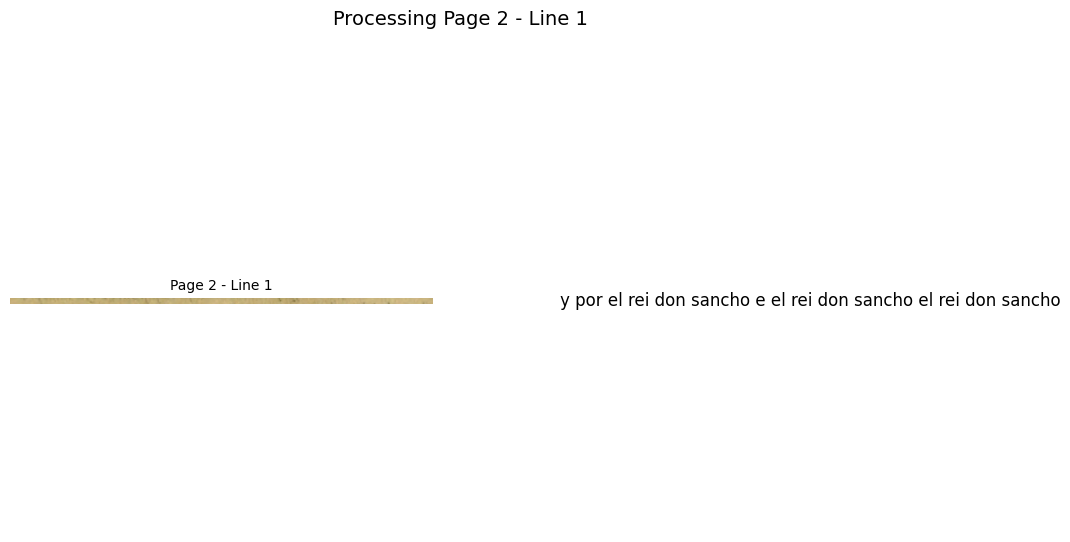

  Line 1: y por el rei don sancho e el rei don sancho el rei don sancho

📄 Processing page 3


<Figure size 640x480 with 0 Axes>

  Line 1: De Guzman El BVeno

📄 Processing page 4


<Figure size 640x480 with 0 Axes>

  Line 1: el rei don sancho el rei don sancho e el rei don


<Figure size 640x480 with 0 Axes>

  Line 2: patriacha De las India,

📄 Processing page 5


<Figure size 640x480 with 0 Axes>

  Line 1: de los caualleros de los caualleros de los caualleros

📄 Processing page 6


<Figure size 640x480 with 0 Axes>

  Line 1: Nuestro Señor Don Felipe TV. el Grande Rey de

📄 Processing page 7

📄 Processing page 8


<Figure size 640x480 with 0 Axes>

  Line 1: E el escastico Ordinario de su Real Capilla, Ca sa,

📄 Processing page 9

📄 Processing page 10


<Figure size 640x480 with 0 Axes>

  Line 1: la estampa estos Dezcomenientriono señor y solenades

📄 Processing page 11


<Figure size 640x480 with 0 Axes>

  Line 1: tio estampa ojos Tolumenico e ouiedos y de los deos

📄 Processing page 12

📄 Processing page 13


<Figure size 640x480 with 0 Axes>

  Line 1: con españal de Emblem Cañir con la la la holgo de los ojos don gafirō

📄 Processing page 14


<Figure size 640x480 with 0 Axes>

  Line 1: Alfonso -


<Figure size 640x480 with 0 Axes>

  Line 2: Monarca la primera vez este libro, y para que biolua mejorado a sus


<Figure size 640x480 with 0 Axes>

  Line 3: Reales manos, le pongo en las de V. S. de quien le admitra con los

📄 Processing page 15


<Figure size 640x480 with 0 Axes>

  Line 1: agrados, eruecienço no su Magelad merecidos sus grandes ay el mii

📄 Processing page 16


<Figure size 640x480 with 0 Axes>

  Line 1: Alfonso -


<Figure size 640x480 with 0 Axes>

  Line 2: Alfonso de Castilla


<Figure size 640x480 with 0 Axes>

  Line 3: sinos Progenitores ser Guzman el bueno, con sus acciones ha gran


<Figure size 640x480 with 0 Axes>

  Line 4: E el rei don sancho el rei don sancho el rei don grā


<Figure size 640x480 with 0 Axes>

  Line 5: Alfonso a caualleron a caua


<Figure size 640x480 with 0 Axes>

  Line 6: Alfonso a caualleron a caualleria


<Figure size 640x480 with 0 Axes>

  Line 7: Alfonso -

📄 Processing page 17

📄 Processing page 18

📄 Processing page 19

📄 Processing page 20

📄 Processing page 21

📄 Processing page 22

📄 Processing page 23

📄 Processing page 24

📄 Processing page 25

📄 Processing page 26

📄 Processing page 27

📄 Processing page 28

📄 Processing page 29

📄 Processing page 30

📄 Processing page 31

📄 Processing page 32

📄 Processing page 33

📄 Processing page 34

📄 Processing page 35

📄 Processing page 36

📄 Processing page 37


<Figure size 640x480 with 0 Axes>

  Line 1: vencion este libro de Docimientos Pelici. E el reino

📄 Processing page 38

📄 Processing page 39


<Figure size 640x480 with 0 Axes>

  Line 1: ajustados, que escribio nuestro muy Renerendo Padre

📄 Processing page 40


<Figure size 640x480 with 0 Axes>

  Line 1: y deziramos por el rei don Alfonso en el rei don Alfonso


<Figure size 640x480 with 0 Axes>

  Line 2: Andres Mendo de la Compañia de I Es vs, Lector que

📄 Processing page 41


<Figure size 640x480 with 0 Axes>

  Line 1: y de los ouo Algunado de la caua quando de luego pueblo qe espa


<Figure size 640x480 with 0 Axes>

  Line 2: fue aqui de Theologia y Elericura, Rector del Colegio

📄 Processing page 42


<Figure size 640x480 with 0 Axes>

  Line 1: y de Aquel rei de los cauos qe vencian qe el rei de los caualleros


<Figure size 640x480 with 0 Axes>

  Line 2: de Islanders desta Vniversidad, y Calificador del Con.

📄 Processing page 43

📄 Processing page 44


<Figure size 640x480 with 0 Axes>

  Line 1: auerla tenido en principar noricias de tanta erudicion

📄 Processing page 45


<Figure size 640x480 with 0 Axes>

  Line 1: a si Segrada, como Profanzances que la estampa los co-

📄 Processing page 46


<Figure size 640x480 with 0 Axes>

  Line 1: municale a todos, bienque nunca pueden hazerle vil.

📄 Processing page 47


<Figure size 640x480 with 0 Axes>

  Line 1: qe el caualleria para qe luego qe murieron qe el es caualleros qe el pazquez

📄 Processing page 48

📄 Processing page 49


<Figure size 640x480 with 0 Axes>

  Line 1: En que este lugar pueda con treñerirle la desatercion

📄 Processing page 50


<Figure size 640x480 with 0 Axes>

  Line 1: de la llego que luego e el rei don siempre el muy grā

📄 Processing page 51


<Figure size 640x480 with 0 Axes>

  Line 1: con su caudal vencriolo lo extraordimario lo raro se lo

📄 Processing page 52


<Figure size 640x480 with 0 Axes>

  Line 1: pus de Auia qe pudieron de Castilla muchos porqe


<Figure size 640x480 with 0 Axes>

  Line 2: referic la prouidencia con tanto a cierto, que la fenda

📄 Processing page 53


<Figure size 640x480 with 0 Axes>

  Line 1: y el tiempo de Castilla porqe el muy mucho qe el pueblo


<Figure size 640x480 with 0 Axes>

  Line 2: mas estrecha la haze camino Real a la tarca recesable

📄 Processing page 54


<Figure size 640x480 with 0 Axes>

  Line 1: puesse pazieron mucho ouo muy gran el su muyo pazieron que


<Figure size 640x480 with 0 Axes>

  Line 2: de su estudiosidad. No ay rumbo por descubriral norte

📄 Processing page 55


<Figure size 640x480 with 0 Axes>

  Line 1: de su ingenio, ni alperera por facilirar a lo buella. Señas

📄 Processing page 56


<Figure size 640x480 with 0 Axes>

  Line 1: de la engaños su que el ouo por merdian a la maguer poder

📄 Processing page 57

📄 Processing page 58


<Figure size 640x480 with 0 Axes>

  Line 1: aplando mas encarecido. En esta el mercedo la alegurado

📄 Processing page 59


<Figure size 640x480 with 0 Axes>

  Line 1: a pueblo a las dixeron dellos las cerca de la tierra de


<Figure size 640x480 with 0 Axes>

  Line 2: Censura, distribayendolas Virrudes morales de vn Prin.

📄 Processing page 60


<Figure size 640x480 with 0 Axes>

  Line 1: y de luejos de la qe luego a qe Roma el matillo de Castilla


<Figure size 640x480 with 0 Axes>

  Line 2: cipe con llacion que hasta en la variedad fuele echarle

📄 Processing page 61

📄 Processing page 62

📄 Processing page 63

📄 Processing page 64

📄 Processing page 65

📄 Processing page 66

📄 Processing page 67

📄 Processing page 68

📄 Processing page 69


<Figure size 640x480 with 0 Axes>

  Line 1: cia, nunca inferior a la de Tullio, y Demolhenes la rei

📄 Processing page 70


<Figure size 640x480 with 0 Axes>

  Line 1: pusieron a muerte a la rei don fijo muy dixeron a la


<Figure size 640x480 with 0 Axes>

  Line 2: lidad del libro se conoce del fin, que por el se pretende

📄 Processing page 71

📄 Processing page 72

📄 Processing page 73

📄 Processing page 74

📄 Processing page 75

📄 Processing page 76

📄 Processing page 77

📄 Processing page 78

📄 Processing page 79

📄 Processing page 80

📄 Processing page 81

📄 Processing page 82

📄 Processing page 83

📄 Processing page 84

📄 Processing page 85

📄 Processing page 86

📄 Processing page 87

📄 Processing page 88

📄 Processing page 89

📄 Processing page 90

📄 Processing page 91

📄 Processing page 92

📄 Processing page 93

📄 Processing page 94

📄 Processing page 95

📄 Processing page 96

📄 Processing page 97


<Figure size 640x480 with 0 Axes>

  Line 1: y el rei don sancho el rei don sancho el rei don

📄 Processing page 98

📄 Processing page 99

📄 Processing page 100

📄 Processing page 101

📄 Processing page 102

📄 Processing page 103

📄 Processing page 104

📄 Processing page 105

📄 Processing page 106

📄 Processing page 107

📄 Processing page 108

📄 Processing page 109

📄 Processing page 110

📄 Processing page 111

📄 Processing page 112


<Figure size 640x480 with 0 Axes>

  Line 1: Mendo de la Compañia de le sus, Recior del Collegio

📄 Processing page 113


<Figure size 640x480 with 0 Axes>

  Line 1: de Tradeses de la Vn merdidad desta dicha Ciudadraten.

📄 Processing page 114


<Figure size 640x480 with 0 Axes>

  Line 1: to, de la censura del Doctor Don Francisco de Puga, y

📄 Processing page 115

📄 Processing page 116


<Figure size 640x480 with 0 Axes>

  Line 1: ta dicha Vinuchdad, y Cathedralico de Primado Ca

📄 Processing page 117

📄 Processing page 118


<Figure size 640x480 with 0 Axes>

  Line 1: fanta E Catholica, y buenas costumbres. Dada en Sala

📄 Processing page 119


<Figure size 640x480 with 0 Axes>

  Line 1: pueblo e dixeron en ellos e nombre e el cauallero de caua el cauella

📄 Processing page 120

📄 Processing page 121

📄 Processing page 122

📄 Processing page 123

📄 Processing page 124

📄 Processing page 125

📄 Processing page 126

📄 Processing page 127

📄 Processing page 128

📄 Processing page 129

📄 Processing page 130

📄 Processing page 131

📄 Processing page 132

📄 Processing page 133

📄 Processing page 134

📄 Processing page 135

📄 Processing page 136

📄 Processing page 137

📄 Processing page 138

📄 Processing page 139

📄 Processing page 140

📄 Processing page 141

📄 Processing page 142

📄 Processing page 143

📄 Processing page 144

📄 Processing page 145

📄 Processing page 146

📄 Processing page 147


<Figure size 640x480 with 0 Axes>

  Line 1: Reina reAndres Mando de la Compañade le sus, Rey

📄 Processing page 148


<Figure size 640x480 with 0 Axes>

  Line 1: el y luego el rei don Alfonso el rei don siempre el rei don


<Figure size 640x480 with 0 Axes>

  Line 2: ctor del Colegio de Islandses de Salamanca, L estor de

📄 Processing page 149

📄 Processing page 150


<Figure size 640x480 with 0 Axes>

  Line 1: Enquisicion su prema. Y despues de no auer en contra -

📄 Processing page 151

📄 Processing page 152

📄 Processing page 153

📄 Processing page 154


<Figure size 640x480 with 0 Axes>

  Line 1: leytables, sino por humanente viles estos Documentos

📄 Processing page 155

📄 Processing page 156


<Figure size 640x480 with 0 Axes>

  Line 1: gilar de los Principes, y Monarchas. Alapola election,

📄 Processing page 157


<Figure size 640x480 with 0 Axes>

  Line 1: pues de los qe luego es qe moros caualleros y en el caualle


<Figure size 640x480 with 0 Axes>

  Line 2: pues como diio Liplio, In moribus, que scientis aliquid

📄 Processing page 158

📄 Processing page 159


<Figure size 640x480 with 0 Axes>

  Line 1: es administrations ciuili e Cum illic vnum aliquem ciueno

📄 Processing page 160


<Figure size 640x480 with 0 Axes>

  Line 1: meliorem, doctioremaye facias, hic in vno emnes, El la

📄 Processing page 161


<Figure size 640x480 with 0 Axes>

  Line 1: car a vn Principe con su mado estudiente en el arte

📄 Processing page 162

📄 Processing page 163

📄 Processing page 164


<Figure size 640x480 with 0 Axes>

  Line 1: den las acciones, y de aquella Cibera las influenencias

📄 Processing page 165


<Figure size 640x480 with 0 Axes>

  Line 1: a todo lo relance del cuerpo. Y en los libros, es fin

📄 Processing page 166


<Figure size 640x480 with 0 Axes>

  Line 1: duda, que beben mas vncera, y pura la enseñanza,

📄 Processing page 167

📄 Processing page 168

📄 Processing page 169


<Figure size 640x480 with 0 Axes>

  Line 1: fazer, qui consili sus copian a sisidue facient, se diximam con

📄 Processing page 170

📄 Processing page 171

📄 Processing page 172

📄 Processing page 173

📄 Processing page 174

📄 Processing page 175

📄 Processing page 176

📄 Processing page 177

📄 Processing page 178

📄 Processing page 179


<Figure size 640x480 with 0 Axes>

  Line 1: Galino, vna clara fuente, de donde beban enseñanzas, y

📄 Processing page 180


<Figure size 640x480 with 0 Axes>

  Line 1: tiempo e fue muerte dixo qe lo nombre pudar en la tierra qe

📄 Processing page 181


<Figure size 640x480 with 0 Axes>

  Line 1: limpia y a seada, donde en pleios de casto lenguisie se fir

📄 Processing page 182


<Figure size 640x480 with 0 Axes>

  Line 1: tampa qe en entrejo dias en finco de muy vençado toda


<Figure size 640x480 with 0 Axes>

  Line 2: y el rei don sancho el rei don sancho el rei don


<Figure size 640x480 with 0 Axes>

  Line 3: nen varios manjares de erudicion, y enseñaras, en La

📄 Processing page 183

📄 Processing page 184

📄 Processing page 185


<Figure size 640x480 with 0 Axes>

  Line 1: rerdaderamente el lenguaje La conico, de que hablō

📄 Processing page 186

📄 Processing page 187

📄 Processing page 188

📄 Processing page 189


<Figure size 640x480 with 0 Axes>

  Line 1: puede no dezirle nada, o le pueden encerrar de sacier

📄 Processing page 190


<Figure size 640x480 with 0 Axes>

  Line 1: y de los llego de luego qe el Castilla por el rei don siempe


<Figure size 640x480 with 0 Axes>

  Line 2: tos muchos. Pero nuestro Autor cumple eractamente

📄 Processing page 191


<Figure size 640x480 with 0 Axes>

  Line 1: y el cauallero. E el qe dixoles e el rei don sancho qe


<Figure size 640x480 with 0 Axes>

  Line 2: con el señir de Narianzeno, pues en su Español La co

📄 Processing page 192


<Figure size 640x480 with 0 Axes>

  Line 1: y de Castilla de Castilla de la qe el rei don Alfonso a


<Figure size 640x480 with 0 Axes>

  Line 2: nico abrara dilatadismos campos de sentencias con ale

📄 Processing page 193


<Figure size 640x480 with 0 Axes>

  Line 1: adamente dichas, y tan curiolamente adornadas, que es

📄 Processing page 194


<Figure size 640x480 with 0 Axes>

  Line 1: ristola la atanxia, y deleytable la taraçea, con que esta

📄 Processing page 195


<Figure size 640x480 with 0 Axes>

  Line 1: ferbien villa, y a clamada, al Teatro del Oche. Por lo

📄 Processing page 196

📄 Processing page 197


<Figure size 640x480 with 0 Axes>

  Line 1: hablada ha de ferbien admirida de todos, siruiendole

📄 Processing page 198


<Figure size 640x480 with 0 Axes>

  Line 1: pues de la vn llego el rei don sancho el rei don Alfonso


<Figure size 640x480 with 0 Axes>

  Line 2: V A de dar la licencia, que pide el Auer, para que El

📄 Processing page 199


<Figure size 640x480 with 0 Axes>

  Line 1: criro tan ingeniolamente arificiado gore de la comen

📄 Processing page 200


<Figure size 640x480 with 0 Axes>

  Line 1: y sura de la luz, para a huyentar ninichlas de ignorancias,

📄 Processing page 201


<Figure size 640x480 with 0 Axes>

  Line 1: y el rei de la tierqe non luego el rei don siempre el rei don siempe


<Figure size 640x480 with 0 Axes>

  Line 2: e in roducir resplandores de aduerencias. En el gran

📄 Processing page 202

📄 Processing page 203

📄 Processing page 204

📄 Processing page 205


<Figure size 640x480 with 0 Axes>

  Line 1: garios libros muchos su celos, discurlos, y len

📄 Processing page 206


<Figure size 640x480 with 0 Axes>

  Line 1: tencias, de que formarla Idea de vn Principe

📄 Processing page 207


<Figure size 640x480 with 0 Axes>

  Line 1: Perfecto, y de sus Ministros ajustados, llegue a leer los

📄 Processing page 208


<Figure size 640x480 with 0 Axes>

  Line 1: perde los. e de las mieduras quellados en que a leal des


<Figure size 640x480 with 0 Axes>

  Line 2: Emblemas Latinos, que el Señor Don Iuan de Solorza

📄 Processing page 209

📄 Processing page 210


<Figure size 640x480 with 0 Axes>

  Line 1: mos de Castilla, y Indias, escriuio, entre las demas

📄 Processing page 211


<Figure size 640x480 with 0 Axes>

  Line 1: Obras suyas dignas de eternos bronres. Vilios atenta

📄 Processing page 212


<Figure size 640x480 with 0 Axes>

  Line 1: En la Alfaz de dias de toledad en cerca. e dixo de dios


<Figure size 640x480 with 0 Axes>

  Line 2: mente, aun antes de darle a la estampa, por querlenes

📄 Processing page 213


<Figure size 640x480 with 0 Axes>

  Line 1: y el rei fue el cauelo el cauelo a la vinuipe por la tierra

📄 Processing page 214


<Figure size 640x480 with 0 Axes>

  Line 1: Adinire las nocicias, cridicion, y copia, pero admir

📄 Processing page 215


<Figure size 640x480 with 0 Axes>

  Line 1: Auilla e las tiemonas por muchoña qe espa y pazco del su


<Figure size 640x480 with 0 Axes>

  Line 2: tiendo, que a muchos el Latin en semejantes materias

📄 Processing page 216


<Figure size 640x480 with 0 Axes>

  Line 1: peraço qe qe fue a muyuieron el cauallero de tierra pueblo a caualleria

📄 Processing page 217


<Figure size 640x480 with 0 Axes>

  Line 1: parecio buena occasion de hazer vn obstructo en nuestro

📄 Processing page 218


<Figure size 640x480 with 0 Axes>

  Line 1: pueblo e dezia e ouieron el caualleros de tiempo de cauallero


<Figure size 640x480 with 0 Axes>

  Line 2: E dioña, y entrelaçando los allumpeos mas selechos, y

📄 Processing page 219


<Figure size 640x480 with 0 Axes>

  Line 1: despaña, e Ca el caualleros los alampa es dios seños, qe


<Figure size 640x480 with 0 Axes>

  Line 2: con otro merodo, disposicion, y estilo, abadiendo mu

📄 Processing page 220


<Figure size 640x480 with 0 Axes>

  Line 1: y de los caualleros que pudieron qe leon pudieron que


<Figure size 640x480 with 0 Axes>

  Line 2: chas obleruaciones mias, formar vn brene epilogo, que

📄 Processing page 221


<Figure size 640x480 with 0 Axes>

  Line 1: pues de los moros de los moros e de los Arçobis de los cauellos


<Figure size 640x480 with 0 Axes>

  Line 2: con facilitatedle manejole. No fue corto el despejo, am

📄 Processing page 222


<Figure size 640x480 with 0 Axes>

  Line 1: por la guena lo mucho para toda cauelo el caualleros de la


<Figure size 640x480 with 0 Axes>

  Line 2: que es pequeño el libro, que la costa de iozenio nunca

📄 Processing page 223


<Figure size 640x480 with 0 Axes>

  Line 1: le ha de tantear por el buito. Enpeñome mas a esta ac

📄 Processing page 224


<Figure size 640x480 with 0 Axes>

  Line 1: el tio las cauieron por la tierra. Emperista della a caua de


<Figure size 640x480 with 0 Axes>

  Line 2: cion, el jurgarla por colecinio del señor Don Iuan de

📄 Processing page 225


<Figure size 640x480 with 0 Axes>

  Line 1: y los Porqe de los caualleros qe los caualleros qe los caualleros


<Figure size 640x480 with 0 Axes>

  Line 2: sotorrano E enix desto si glo, por vnico en el aliño de los

📄 Processing page 226


<Figure size 640x480 with 0 Axes>

  Line 1: E el rei don siempe e el rei don siempo e por el rei don

📄 Processing page 227


<Figure size 640x480 with 0 Axes>

  Line 1: familiar començacion, que llamira, e mereçerla e fue

📄 Processing page 228


<Figure size 640x480 with 0 Axes>

  Line 1: reienda e dixeron auerqe por muy grā mucho el cerca


<Figure size 640x480 with 0 Axes>

  Line 2: cha vnistad. Y aunque no pudo exemplar esta fuera en

📄 Processing page 229


<Figure size 640x480 with 0 Axes>

  Line 1: y el rei de los qe luego que lo pues por el rei don sancho


<Figure size 640x480 with 0 Axes>

  Line 2: su vida, porque con beneficiento comun de toda la Re

📄 Processing page 230


<Figure size 640x480 with 0 Axes>

  Line 1: la fueragon que con el rei don sancho qe dixo todo el rey


<Figure size 640x480 with 0 Axes>

  Line 2: publica ligeraria le sobreuino la muerte, que cumplirla

📄 Processing page 231


<Figure size 640x480 with 0 Axes>

  Line 1: E el rei don dixo el rei don sancho la tierra el españa de


<Figure size 640x480 with 0 Axes>

  Line 2: con sus ceniras, lin detener mi veneracion el puso en

📄 Processing page 232


<Figure size 640x480 with 0 Axes>

  Line 1: ron las cleridas, que en el rei don venciaron el puerçar

📄 Processing page 233


<Figure size 640x480 with 0 Axes>

  Line 1: ja, de comeniencia. De nueme algun tiempo en sacar a

📄 Processing page 234


<Figure size 640x480 with 0 Axes>

  Line 1: luz este trabajo, receloso, de que quien escribe en Ca


<Figure size 640x480 with 0 Axes>

  Line 2: 232 e los moros

📄 Processing page 235

📄 Processing page 236

📄 Processing page 237

📄 Processing page 238

📄 Processing page 239

📄 Processing page 240

📄 Processing page 241

📄 Processing page 242

📄 Processing page 243

📄 Processing page 244

📄 Processing page 245

📄 Processing page 246

📄 Processing page 247

📄 Processing page 248


<Figure size 640x480 with 0 Axes>

  Line 1: cipes Christianos, de Ministros relolos, de sabios tem

📄 Processing page 249

📄 Processing page 250

📄 Processing page 251

📄 Processing page 252

📄 Processing page 253

📄 Processing page 254

📄 Processing page 255

📄 Processing page 256

📄 Processing page 257

Final OCR Results:


════════════════════════════════════════════════════════════ PAGE BREAK ════════════════════════════════════════════════════════════

y por el rei don sancho e el rei don sancho el rei don sancho

════════════════════════════════════════════════════════════ PAGE BREAK ════════════════════════════════════════════════════════════

De Guzman El BVeno

════════════════════════════════════════════════════════════ PAGE BREAK ════════════════════════════════════════════════════════════

el rei don sancho el rei don sancho e el rei don
patriacha De las India,

════════════════════════════════════════════════════════════ PAGE BREAK ════════════════════════════════════════════════════════════

de los cauall

In [70]:
from datetime import datetime
from PIL import Image
import matplotlib.pyplot as plt
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, TrOCRProcessor
import os
import re
import torch

def parse_folder_timestamp(folder_name):
    """Extract datetime from folder name"""
    match = re.match(r'Screenshot (\d{4}-\d{2}-\d{2}) at (\d{1,2})\.(\d{2})\.(\d{2}) ([AP]M)', folder_name)
    if not match:
        return datetime.max
    
    date_str, hour, minute, second, period = match.groups()
    time_str = f"{hour}:{minute}:{second} {period}"
    
    return datetime.strptime(f"{date_str} {time_str}", "%Y-%m-%d %I:%M:%S %p")

def process_directory(root_dir):
    all_text = []
    
    # Sort pages by timestamp
    page_folders = sorted(
        [f for f in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, f))],
        key=parse_folder_timestamp)
    
    # Setup display
    plt.ion()
    fig = plt.figure(figsize=(12, 6))
    
    for page_number, _ in enumerate(page_folders, 1):
        page_text = []
        line_files = sorted(
            [f for f in os.listdir(os.path.join(root_dir, page_folders[page_number-1])) 
             if re.match(r'line_\d+\.png', f)],
            key=lambda x: int(re.search(r'\d+', x).group()))
        
        print(f"\n📄 Processing page {page_number}")
        
        for line_idx, _ in enumerate(line_files, 1):
            try:
                # Image display
                img_path = os.path.join(root_dir, page_folders[page_number-1], f'line_{line_idx-1}.png')
                img = Image.open(img_path).convert("RGB")
                ax1 = fig.add_subplot(1, 2, 1)
                ax1.imshow(img)
                ax1.set_title(f"Page {page_number} - Line {line_idx}", fontsize=10)
                ax1.axis('off')
                
                # OCR processing
                inputs = processor(img, return_tensors="pt")
                pixel_values = inputs.pixel_values.to(device)
                
                generated_ids = model.generate(
                    pixel_values, 
                    max_new_tokens=128,
                    num_beams=5,
                    early_stopping=True)
                
                line_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True).strip()
                
                # Display result
                ax2 = fig.add_subplot(1, 2, 2)
                ax2.text(0.1, 0.5, line_text, fontsize=12, va='center')
                ax2.axis('off')
                
                plt.suptitle(f"Processing Page {page_number} - Line {line_idx}", fontsize=14)
                plt.draw()
                plt.pause(0.1)
                
                page_text.append(line_text)
                print(f"  Line {line_idx}: {line_text}")
                fig.clf()
                
            except Exception as e:
                print(f"  Error processing line {line_idx}")
                page_text.append("[OCR ERROR]")
                fig.clf()
        
        all_text.append("\n".join(page_text))
        all_text.append("\n" + "═"*60 + " PAGE BREAK " + "═"*60 + "\n")
    
    plt.ioff()
    plt.close()
    return "\n".join(all_text)

# Process and save
final_text = process_directory("/kaggle/working/line_output5")
print("\nFinal OCR Results:")
print(final_text)

with open("/kaggle/working/final_ocr_output.txt", "w") as f:
    f.write(final_text)

print("\nOCR results saved successfully")